# Configuration

In [1]:
import sys
if sys.version_info[0] < 3 or sys.version_info[1] < 6:
    raise Exception("Must be using Python >= 3.6 due to reliance on ordered default dict.")
else:
    print("[INFO] Running python {}.{}.{}".format(*sys.version_info[:3]))

[INFO] Running python 3.7.3


## Packages to import

In [2]:
def run_from_ipython():
    try:
        __IPYTHON__
        return True
    except NameError:
        return False
from platform import python_version

version = "[INFO] Running python {}".format(python_version())
version += " for ipython" if run_from_ipython() else ""
print(version)

[INFO] Running python 3.7.3 for ipython


In [3]:
if run_from_ipython():
    %load_ext autoreload
    %autoreload 2
    %matplotlib notebook

from secScraper import *

import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import os
import csv
from datetime import datetime
import re
from tqdm import tqdm
import multiprocessing as mp
from collections import OrderedDict
import time
import pandas as pd
import argparse
import psycopg2
import ast

# Spark
#import findspark
#findspark.init('/home/alex/spark-2.4.4-bin-hadoop2.7')
import pyspark

### Set the nb of processes to use based on cmd line arguments/setting

In [4]:
if run_from_ipython():
    nb_processes_requested = mp.cpu_count()  # From IPython, fixed setting
    nb_processes_requested = 1 # From IPython, fixed setting
else:
    ap = argparse.ArgumentParser()
    ap.add_argument("-p", "--processes", type=int, default=1, help="Number of processes launched to process the reports.")
    args = vars(ap.parse_args())
    nb_processes_requested = args["processes"]
    if not 1 <= nb_processes_requested <= mp.cpu_count():
        raise ValueError('[ERROR] Number of processes requested is incorrect.\
                         \n{} CPUs are available on this machine, please select a number of processes between 1 and {}'
                         .format(mp.cpu_count()))

## Settings dictionary

In [5]:
home = os.path.expanduser("~")
_s = {
    'path_stage_1_data': os.path.join(home, 'Desktop/filtered_text_data/nd_data/'),
    'path_stock_database': os.path.join(home, 'Desktop/Insight project/Database/Ticker_stock_price.csv'),
    'path_stock_indexes': os.path.join(home, 'Desktop/Insight project/Database/Indexes/'),
    'path_cik_ticker_lookup': os.path.join(home, 'Desktop/Insight project/Database/cik_ticker.csv'),
    'path_master_dictionary': os.path.join(home, 'Desktop/Insight project/Database/LoughranMcDonald_MasterDictionary_2018.csv'),
    'path_dump_crsp': os.path.join(home, 'Desktop/Insight project/Database/dump_crsp_merged.txt'),
    'path_output_folder': os.path.join(home, 'Desktop/Insight project/Outputs'),
    'path_dump_cik_scores': os.path.join(home, 'Desktop/Insight project/Outputs/dump_cik_scores.csv'),
    'path_dump_pf_values': os.path.join(home, 'Desktop/Insight project/Outputs/dump_pf_values.csv'),
    'path_dump_master_dict': os.path.join(home, 'Desktop/Insight project/Outputs/dump_master_dict.csv'),
    'metrics': ['diff_jaccard', 'diff_cosine_tf', 'diff_cosine_tf_idf', 'diff_minEdit', 'diff_simple', 'sing_LoughranMcDonald'],
    'differentiation_mode': 'monthly',
    'time_range': [(2010, 1), (2012, 4)],
    'bin_count': 5,
    'tax_rate': 0.005,
    'report_type': ['10-K', '10-Q'],
    'sections_to_parse_10k': [],
    'sections_to_parse_10q': [],
    'type_daily_price': 'closing'
}

In [6]:
_s['pf_init_value'] = 1000000
_s['epsilon'] = 0.0001  # Rounding error
# Calculated settings
_s['list_qtr'] = qtrs.create_qtr_list(_s['time_range'])

if _s['bin_count'] == 5:
    _s['bin_labels'] = ['Q'+str(n) for n in range(1, _s['bin_count']+1)]
elif _s['bin_count'] == 10:
    _s['bin_labels'] = ['D'+str(n) for n in range(1, _s['bin_count']+1)]
else:
    raise ValueError('[ERROR] This type of bin has not been implemented yet.')

# Reports considered to calculate the differences
if _s['differentiation_mode'] == 'monthly':
    _s['lag'] = 1
    _s['sections_to_parse_10k'] = ['1a', '3', '7', '7a', '9a']
    _s['sections_to_parse_10q'] = ['_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a']
elif _s['differentiation_mode'] == 'yearly':
    _s['lag'] = 4
    _s['sections_to_parse_10k'] = ['1a', '3', '7', '7a', '9a']
    _s['sections_to_parse_10q'] = ['_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a']

_s['intersection_table'] = {
        '10-K': ['1a', '3', '7', '7a', '9a'],
        '10-Q': ['ii_1a', 'ii_1', '_i_2', '_i_3', '_i_4']
}  # Exhibits are not taken into account
_s['straight_table'] = {
    '10-K': ['1', '1a', '1b', '2', '3', '4', '5', '6', '7', '7a', '8', '9', '9a', '9b', '10', '11', '12', '13', '14', '15'],
    '10-Q': ['_i_1', '_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a', 'ii_2', 'ii_3', 'ii_4', 'ii_5', 'ii_6']
}

In [7]:
# Transfer s to a read only dict
read_only_dict = pre_processing.ReadOnlyDict()
for key in _s:  # Brute force copy
    read_only_dict[key] = _s[key]
s = read_only_dict  # Copy back
s.set_read_state(read_only=True)  # Set as read only

# Load external tables

In [64]:
connector = psycopg2.connect(host="localhost", dbname="postgres", user="postgres", password="1")

## Extract the list of CIK for which we have complete data

The main problem in our case is that we have 3 different database to play with:
1. The SEC provides information based on the CIK of the entity
2. Given that the CIK is used by no one else, we use a lookup table to transform that into tickers. But we do not have all the correspondances, so the list of useful CIK is shrunk.
3. Finally, we only have stock prices for so many tickers. So that shrinks the CIK list even further.

We end up with a reduced list of CIK that we can play with.

### Load the sentiment analysis dictionary

In [8]:
lm_dictionary = Load_MasterDictionary.load_masterdictionary(s['path_master_dictionary'], True)

 ...Loading Master Dictionary 85000
Master Dictionary loaded from file: 
  /home/alex/Desktop/Insight project/Database/LoughranMcDonald_MasterDictionary_2018.csv
  86,486 words loaded in master_dictionary.



### Find all the unique CIK from the SEC filings

In [9]:
cik_path = pre_processing.load_cik_path(s)

[INFO] Loaded 306,198 10-X
[INFO] Shrunk to 276,841 ['10-K', '10-Q']


 34%|███▍      | 94958/276841 [00:00<00:00, 949576.38it/s]

[INFO] Found 14,549 unique CIK in master index


100%|██████████| 276841/276841 [00:00<00:00, 982018.45it/s]

[INFO] cik_path contains data on 14,549 CIK numbers


### Get the largest {CIK: ticker} possible given our lookup table

In [10]:
lookup = pre_processing.load_lookup(s)
print("[INFO] Loaded {:,} CIK/Tickers correspondances.".format(len(lookup)))

[INFO] Loaded 13,738 CIK/Tickers correspondances.


In [11]:
cik_path, lookup = pre_processing.intersection_sec_lookup(cik_path, lookup)
print("[INFO] Intersected SEC & lookup.")
print("cik_path: {:,} CIK | lookup: {:,} CIK"
      .format(len(cik_path), len(lookup)))

[INFO] Intersected SEC & lookup.
cik_path: 8,207 CIK | lookup: 8,207 CIK


### Load stock data and drop all CIKs for which we don't have data

In [12]:
# Load all stock prices
stock_data = pre_processing.load_stock_data(s)

  0%|          | 59848/30563446 [00:00<00:50, 598477.72it/s]

[INFO] Loading data from (2010, 1) to (2012, 4)
[INFO] Starting the mapping


100%|██████████| 30563446/30563446 [01:06<00:00, 462638.63it/s]


In [62]:
stock_data['BTFG']

{datetime.date(2010, 1, 4): (3.25, 57310500.0),
 datetime.date(2010, 1, 5): (2.94, 51843960.0),
 datetime.date(2010, 1, 6): (2.79, 49198860.0),
 datetime.date(2010, 1, 7): (2.76, 48669840.0),
 datetime.date(2010, 1, 8): (2.94, 51843960.0),
 datetime.date(2010, 1, 11): (2.85, 50256900.0),
 datetime.date(2010, 1, 12): (2.84, 50080560.0),
 datetime.date(2010, 1, 13): (2.83, 49904220.0),
 datetime.date(2010, 1, 14): (2.85, 50256900.0),
 datetime.date(2010, 1, 15): (2.89, 50962260.0),
 datetime.date(2010, 1, 19): (2.81, 49551540.0),
 datetime.date(2010, 1, 20): (2.85, 50256900.0),
 datetime.date(2010, 1, 21): (3.15, 55547100.0),
 datetime.date(2010, 1, 22): (3.22, 56781480.0),
 datetime.date(2010, 1, 25): (3.2, 56428800.0),
 datetime.date(2010, 1, 26): (3.94, 69477960.0),
 datetime.date(2010, 1, 27): (3.97, 70006980.0),
 datetime.date(2010, 1, 28): (3.97, 70006980.0),
 datetime.date(2010, 1, 29): (3.92, 69125280.0),
 datetime.date(2010, 2, 1): (3.89, 68596260.0),
 datetime.date(2010, 2, 2):

In [60]:
header_stock_data = (('TICKER', 'text'), ('DATE', 'date'),
                    ('ASK', 'float'), ('SHROUT', 'integer'))
postgres.stock_data_to_postgres(connector, stock_data, header_stock_data)

dict_keys(['BTFG', 'AEPI', 'JJSF', 'DGSE', 'PLXS', 'RMCF', 'HGR', 'KDE', 'AMCE', 'ORCL', 'MSFT', 'ACUR', 'AYE', 'TROW', 'OSIP', 'HON', 'EMC', 'AMRC', 'XRIT', 'TECD', 'RGEN', 'AT', 'LSBX', 'BWC', 'BEAM', 'BWINB', 'INDB', 'DMC', 'TSTF', 'SIGM', 'TKLC', 'HGIC', 'HVT', 'NHTB', 'LLTC', 'CY', 'AMFI', 'TMP', 'BCPC', 'GENZ', 'XOMA', 'ADPT', 'DJCO', 'AMAG', 'TCB', 'ASTE', 'NAVG', 'WERN', 'SKYW', 'PATR', 'REFR', 'AMWD', 'MDCI', 'TWMC', 'ADM', 'AAN', 'VIVO', 'CLFD', 'PDEX', 'FEP', 'WTS', 'FNB', 'HNBC', 'TGX', 'LAKE', 'PTSI', 'ACET', 'BRLI', 'CYAN', 'FSYS', 'HLS', 'FISV', 'CEBK', 'SED', 'FCNCA', 'RWC', 'BKSC', 'HTLD', 'TSFG', 'CYTR', 'RENT', 'OSUR', 'BWS', 'BC', 'DXYN', 'UIS', 'WSFS', 'ITIC', 'CERN', 'FFKT', 'WBS', 'MKL', 'CMVT', 'CDR', 'ACMP', 'FLIC', 'FBP', 'NWK', 'PMD', 'EPG', 'STSA', 'DELL', 'ASBI', 'SYNO', 'PARL', 'AVD', 'PLAB', 'AIM', 'JEN', 'MESA', 'CRMT', 'AGII', 'OFG', 'CFNB', 'CATO', 'FBNC', 'ICCC', 'WSBC', 'KO', 'SAFM', 'CNBKA', 'ECT', 'AIRT', 'UBSI', 'ENV', 'CCC', 'CMRG', 'SKS', 'SWTX'

In [13]:
path = os.path.join(home, 'Desktop/Insight project/Database/stock_data_filtered.csv')

In [14]:
header = ['IDX', 'TICKER', 'TIMESTAMP', 'ASK', 'MARKET_CAP']

In [15]:
with open(path, 'w') as f:
    out = csv.writer(f, delimiter=';')
    out.writerow(header)
    idx = 0
    for ticker in tqdm(stock_data):
        for ts in stock_data[ticker]:
            #print(ts)
            out.writerow([idx, ticker, ts, stock_data[ticker][ts][0], stock_data[ticker][ts][1]])
            idx += 1

100%|██████████| 5178/5178 [00:07<00:00, 660.67it/s]


In [16]:
lookup, stock_data = pre_processing.intersection_lookup_stock(lookup, stock_data)
print("[INFO] Intersected lookup & stock data.")
print("lookup: {:,} tickers | stock_data: {:,} tickers"
      .format(len(lookup.values()), len(stock_data)))

4668
[INFO] Intersected lookup & stock data.
lookup: 4,791 tickers | stock_data: 4,668 tickers


### Load stock indexes - will serve as benchmark later on

In [17]:
index_data = pre_processing.load_index_data(s)
print("[INFO] Loaded the following index data:", list(index_data.keys()))

[INFO] Loaded the following index data: ['IXIC', 'SPX', 'DJI', 'RUT']


In [21]:
header_index_data = (('DATE', 'date'), ('ASK', 'float'))
postgres.index_data_to_postgres(connector, index_data, header_index_data)

  0%|          | 0/4 [00:00<?, ?it/s]

[INFO] Deleted table index_data
[INFO] Creating the following table:
CREATE TABLE index_data(IDX integer PRIMARY KEY,DATE date,ASK float)


100%|██████████| 4/4 [00:38<00:00,  9.47s/it]


## Back propagate these intersection all the way to cik_path

Technically, we have just done it for lookup. So we only need to re-run an intersection for lookup and sec.

In [22]:
cik_path, lookup = pre_processing.intersection_sec_lookup(cik_path, lookup)
print("[INFO] Intersected SEC & lookup.")
print("cik_path: {:,} CIK | lookup: {:,} CIK"
      .format(len(cik_path), len(lookup)))

[INFO] Intersected SEC & lookup.
cik_path: 4,791 CIK | lookup: 4,791 CIK


## Sanity check

At this point, cik_path and lookup should have the same number of keys as the CIK is unique in the path database.

However, multiple CIK can redirect to the same ticker if the company changed its ticker over time. That should be a very limited amount of cases though.

In [23]:
assert cik_path.keys() == lookup.keys()
assert len(set(lookup.values())) == len(set(stock_data.keys()))

At that point, we have a {CIK: ticker} for which the stock is known, which will enable comparison and all down the road.

## Review all CIKs: make sure there is only one submission per quarter

In this section, the goal is to build a list of CIK that will successfully be parsed for the time_range considered.
It should be trivial for a vast majority of the CIK, but ideally there should be only one document per quarter for each CIK from the moment they are listed to the moment they are delisted.

In [24]:
# Create the list of quarters to consider
cik_path = pre_processing.review_cik_publications(cik_path, s)
print("[INFO] Removed all the CIK that did not have one report per quarter.")
print("cik_dict: {:,} CIK".format(len(cik_path)))

100%|██████████| 4791/4791 [00:00<00:00, 10081.72it/s]



[INFO] 1387 CIKs caused trouble
[INFO] Removed all the CIK that did not have one report per quarter.
cik_dict: 3,404 CIK


In [25]:
print("[INFO] We are left with {:,} CIKs that meet our requirements:".format(len(cik_path)))
print("- The ticker can be looked up in the CIK/ticker tabke")
print("- The stock data is available for that ticker")
print("- There is one and only one report per quarter")

[INFO] We are left with 3,404 CIKs that meet our requirements:
- The ticker can be looked up in the CIK/ticker tabke
- The stock data is available for that ticker
- There is one and only one report per quarter


## Dump all the data to postgres
This is done so that the Flask webapp can retrieve the settings that were used at a later time.

postgres.settings_to_postgres(connector, s)

header_lookup = (('CIK', 'integer'), ('TICKER', 'text'))
postgres.lookup_to_postgres(connector, lookup, header_lookup)

In [65]:
header = (('TICKER', 'text'), ('TIMESTAMP', 'date'), 
          ('ASK', 'float'), ('MARKET_CAP', 'float'))
path = os.path.join(home, 'Desktop/Insight project/Database/stock_data_filtered.csv')
postgres.stock_data_csv_to_postgres(connector, path, header)

[INFO] Deleted table stock_data
[INFO] Creating the following table:
CREATE TABLE stock_data(IDX integer PRIMARY KEY,TICKER text,TIMESTAMP date,ASK float,MARKET_CAP float)


stock_data_2 = postgres.retrieve_stock_data(connector)

# Parse files

Now we have a list of CIK that should make it until the end. It is time to open the relevant reports and start parsing. This step takes a lot of time and can get arbitrarily long as the metrics get fancier.

You do not want to keep in RAM all the parsed data. However, there are only ~100 quarters for which we have data and the stage 2 files are no more than 1 Mb in size (Apple seems to top out at ~ 325 kb). So 100 Mb per core + others, that's definitely doable. More cores will use more RAM, but the usage remains reasonable.

We use multiprocessing to go through N CIK at once but a single core is dedicated to going through a given CIK for the specified time_range. Such a core can be running for a while if the company has been in business for the whole time_range and publish a lot of text data in its 10-K.

In [26]:
try:
    sc.stop()
except:
    pass
nb_processes_requested = 8

In [27]:
# Processing the reports will be done in parrallel in a random order
# Settings in s are cast to dict for pickling - the custom class is not supported
nb_cik_to_process = 100
cik_path = {k: v for k, v in cik_path.items() if k in list(cik_path.keys())[:nb_cik_to_process]}
cik_scores = {k: 0 for k in cik_path.keys()}  # Organized by ticker
data_to_process = ([k, v, {**s}, lm_dictionary] for k, v in cik_path.items())
assert cik_path.keys() == cik_scores.keys()
#print(data_to_process)
#result = process_cik(data_to_process[0])
#cik_perf[result[0]] = result[1]
#print(cik_perf)
#assert 0
processing_stats = [0, 0, 0, 0, 0, 0]
#qtr_metric_result = {key: [] for key in s['list_qtr']}
if nb_processes_requested > 1:
    with mp.Pool(processes=nb_processes_requested) as p:
    #with mp.Pool(processes=min(mp.cpu_count(), 1)) as p:
        print("[INFO] Starting a pool of {} workers".format(nb_processes_requested))

        with tqdm(total=nb_cik_to_process) as pbar:
            for i, value in tqdm(enumerate(p.imap_unordered(processing.process_cik, data_to_process))):
                pbar.update()
                #qtr = list_qtr[i]
                # Each quarter gets a few metrics
                if value[1] == {}:
                    # The parsing failed
                    del cik_scores[value[0]]
                else:
                    cik_scores[value[0]] = value[1]
                processing_stats[value[2]] += 1

elif nb_processes_requested == 1:
    print("[INFO] Running on {} core (multiprocessing is off)".format(nb_processes_requested))
    with tqdm(total=nb_cik_to_process) as pbar:
        for i, value in tqdm(enumerate(map(processing.process_cik, data_to_process))):
            pbar.update()
            #qtr = list_qtr[i]
            # Each quarter gets a few metrics
            if value[1] == {}:
                # The parsing failed
                del cik_scores[value[0]]
            else:
                cik_scores[value[0]] = value[1]
            processing_stats[value[2]] += 1

elif nb_processes_requested == 0:
    # Spark mode!!
    print("[INFO] Running with Spark")
    sc = pyspark.SparkContext(appName="model_calculations")
    print("[INFO] Context started")
    spark_result = sc.parallelize(data_to_process).map(processing.process_cik)
    spark_result = spark_result.take(nb_cik_to_process)
    sc.stop()
    
    # Process the result
    with tqdm(total=nb_cik_to_process) as pbar:
        for i, value in tqdm(enumerate(spark_result)):
            pbar.update()
            #qtr = list_qtr[i]
            # Each quarter gets a few metrics
            if value[1] == {}:
                # The parsing failed
                del cik_scores[value[0]]
            else:
                cik_scores[value[0]] = value[1]
            processing_stats[value[2]] += 1
           
        #qtr_metric_result[value['0']['qtr']] = value
print("[INFO] {} CIK failed to be processed.".format(sum(processing_stats[1:])))
print("Detailed stats and error codes:", processing_stats)

  0%|          | 0/100 [00:00<?, ?it/s]


[INFO] Starting a pool of 8 workers


0it [00:00, ?it/s]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.3860537945783969, 'diff_cosine_tf': 0.801119807207378, 'diff_cosine_tf_idf': 0.7755372337509133, 'diff_minEdit': 0.844539146155044, 'diff_simple': 0.7422182867262703, 'sing_LoughranMcDonald': -0.0016647563700913082, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 3), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.849773016926045, 'diff_cosine_tf': 0.991424873394707, 'diff_cosine_tf_idf': 0.9897739952229097, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.001411784041286702, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.8165114586808954, 'diff_cosine_tf': 0.9931562811226052, 'diff_cosine_tf_idf': 0.9899288855527351, 'diff_minEdit': 0.9067664632595982, 'diff_simple': 0.9

  1%|          | 1/100 [00:04<07:19,  4.44s/it]
1it [00:04,  4.19s/it]

[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9732124819624819, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.23276236455665106, 'diff_cosine_tf': 0.5720100602546653, 'diff_cosine_tf_idf': 0.5606708666171527, 'diff_minEdit': 0.7224201606056532, 'diff_simple': 0.6032467853344146, 'sing_LoughranMcDonald': -0.0015815906323559327, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.


  2%|▏         | 2/100 [00:05<05:21,  3.28s/it]

{'diff_jaccard': 0.7674770704370789, 'diff_cosine_tf': 0.9807262342971406, 'diff_cosine_tf_idf': 0.9784421144168743, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0016215781496927884, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.5813189197503261, 'diff_cosine_tf': 0.9434701912622426, 'diff_cosine_tf_idf': 0.9321592950521267, 'diff_minEdit': 0.991436795394579, 'diff_simple': 0.9771959153255856, 'sing_LoughranMcDonald': -0.0017205719201292757, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.0014269945956714484, 'diff_cosine_tf': 0.0786638084494358, 'diff_cosine_tf_idf': 0.047711975611118215, 'diff_minEdit': 0.6664487788555444, 'diff_


2it [00:04,  3.10s/it]

{'diff_jaccard': 0.057775567688266125, 'diff_cosine_tf': 0.6252866772318253, 'diff_cosine_tf_idf': 0.5260838656893679, 'diff_minEdit': 0.8722689219377792, 'diff_simple': 0.7872004960727574, 'sing_LoughranMcDonald': 0.00025072791882523146, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
{'diff_jaccard': 0.8134297667949074, 'diff_cosine_tf': 0.9938677316429787, 'diff_cosine_tf_idf': 0.9935633610452812, 'diff_minEdit': 0.9392802556620814, 'diff_simple': 0.9908920383493123, 'sing_LoughranMcDonald': -0.0004679442549336972, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.8007364198422311, 'diff_cosine_tf': 0.9830802790753731, 'diff_cosine_tf_idf': 0.981173716905914, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0015930599359247966, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2011, 1) from 1 quarter a

  4%|▍         | 4/100 [00:05<03:49,  2.39s/it]
4it [00:05,  2.27s/it]

{'diff_jaccard': 0.6315610713014862, 'diff_cosine_tf': 0.9528539526605745, 'diff_cosine_tf_idf': 0.942433069958026, 'diff_minEdit': 0.9999189792798313, 'diff_simple': 0.9999773141983528, 'sing_LoughranMcDonald': -0.0001316399355698108, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.6943321152995425, 'diff_cosine_tf': 0.9724728156379844, 'diff_cosine_tf_idf': 0.9626765772182617, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004512524302679506, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 31), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.006136519387537108, 'diff_cosine_tf': 0.3173558920238464, 'diff_cosine_tf_idf': 0.23471971690704677, 'diff_minEdit': 0.9429582585938879, 'diff_simple': 0.6831513544542338, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 27), 'qtr': (2012, 1)}}
[INFO] Compa

  5%|▌         | 5/100 [00:06<02:52,  1.81s/it]
5it [00:05,  1.73s/it]

{'diff_jaccard': 0.006799448806233028, 'diff_cosine_tf': 0.28310510490733964, 'diff_cosine_tf_idf': 0.21671498697845026, 'diff_minEdit': 0.9557130133393559, 'diff_simple': 0.62207160810011, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 24), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.23979162555265054, 'diff_cosine_tf': 0.8489382178576539, 'diff_cosine_tf_idf': 0.8266530459639843, 'diff_minEdit': 0.7963698076921925, 'diff_simple': 0.5912339217105629, 'sing_LoughranMcDonald': -0.0031169712684809936, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 17), 'qtr': (2010, 2)}}


  6%|▌         | 6/100 [00:06<02:14,  1.43s/it]

[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7161852412155307, 'diff_cosine_tf': 0.9671925439119831, 'diff_cosine_tf_idf': 0.9571053487380847, 'diff_minEdit': 0.9957909710890758, 'diff_simple': 0.9928236057068741, 'sing_LoughranMcDonald': -0.00251480669668803, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.01391655306259937, 'diff_cosine_tf': 0.39555094961323, 'diff_cosine_tf_idf': 0.30558551885745666, 'diff_minEdit': 0.9535362033176746, 'diff_simple': 0.7512382626233444, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 12), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.0041423439023364, 'diff_cosine_tf': 0.22797490418859814, 'diff_cosine_tf_idf': 0.17683583402948994, 'diff_minEdit': 0.9345534600489792,


  7%|▋         | 7/100 [00:07<01:49,  1.18s/it]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.


{'diff_jaccard': 0.02813983545478716, 'diff_cosine_tf': 0.40278891626086166, 'diff_cosine_tf_idf': 0.33764900614785087, 'diff_minEdit': 0.5874725896509647, 'diff_simple': 0.3198509058441692, 'sing_LoughranMcDonald': -0.0004120140604825729, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.6997931529754196, 'diff_cosine_tf': 0.9510660419064216, 'diff_cosine_tf_idf': 0.9246621323393246, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00013051161419977983, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.7905335570616423, 'diff_cosine_tf': 0.9653759955511614, 'diff_cosine_tf_idf': 0.9448199509906019, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -7.624456138259145e-05, '0': {'type': '10-Q', 'publishe

7it [00:07,  1.23s/it]

{'diff_jaccard': 0.026459162255798793, 'diff_cosine_tf': 0.43483605161797684, 'diff_cosine_tf_idf': 0.37235627105737773, 'diff_minEdit': 0.5874571580624396, 'diff_simple': 0.31830699474852475, 'sing_LoughranMcDonald': -0.0007636173811229666, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 7), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.


  8%|▊         | 8/100 [00:08<01:44,  1.14s/it]

{'diff_jaccard': 0.8019866496881459, 'diff_cosine_tf': 0.9579201422186562, 'diff_cosine_tf_idf': 0.9438773770926842, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0006814447387397063, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}


[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.7282278894322793, 'diff_cosine_tf': 0.9699981693018556, 'diff_cosine_tf_idf': 0.9511141568238223, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007748417286284709, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}


8it [00:08,  1.02s/it]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.0038830225383650503, 'diff_cosine_tf': 0.059254866931442836, 'diff_cosine_tf_idf': 0.03437572186058513, 'diff_minEdit': 0.5500506783459332, 'diff_simple': 0.23413693949923306, 'sing_LoughranMcDonald': 0.00026361509441788077, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.021890058737573326, 'diff_cosine_tf': 0.09420557945305891, 'diff_cosine_tf_idf': 0.06149226868469172, 'diff_minEdit': 0.6900884132154491, 'diff_simple': 0.13847733190299763, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quar

  9%|▉         | 9/100 [00:08<01:30,  1.00it/s]
9it [00:08,  1.08it/s]

{'diff_jaccard': 1.0, 'diff_cosine_tf': 0.9999999999999999, 'diff_cosine_tf_idf': 0.9999999999999999, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.020793024098900204, 'diff_cosine_tf': 0.3720756289996961, 'diff_cosine_tf_idf': 0.32053879098052995, 'diff_minEdit': 0.6943824233670123, 'diff_simple': 0.6020676382482334, 'sing_LoughranMcDonald': -0.0001546644065347483, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 4), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.2755687908933065, 'diff_cosine_tf': 0.7346819789772654, 'diff_cosine_tf_idf': 0.721416538129546, 'diff_minEdit': 0.8243259904190772, 'diff_simple': 0.6945051174768063, 'sing_LoughranMcDonald': -0.00044268957344010575, '0': {'type': '10-Q', 'published': 

 10%|█         | 10/100 [00:09<01:19,  1.13it/s]
10it [00:09,  1.21it/s]

{'diff_jaccard': 0.7085330776605945, 'diff_cosine_tf': 0.9590137408308428, 'diff_cosine_tf_idf': 0.9498495082947558, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0010935884360732432, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.


 11%|█         | 11/100 [00:10<01:11,  1.25it/s]

{'diff_jaccard': 0.061177510024700815, 'diff_cosine_tf': 0.6242334544691605, 'diff_cosine_tf_idf': 0.5675637619559952, 'diff_minEdit': 0.7355078956952494, 'diff_simple': 0.5192221884175944, 'sing_LoughranMcDonald': -0.0016417580386797576, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 2), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.7326448047865067, 'diff_cosine_tf': 0.9851481834701358, 'diff_cosine_tf_idf': 0.9829105405059909, 'diff_minEdit': 0.9976902840326393, 'diff_simple': 0.9986141704195836, 'sing_LoughranMcDonald': -0.00046675215350763756, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.8132252504638676, 'diff_cosine_tf': 0.9760194583059744, 'diff_cosine_tf_idf': 0.9631350216876738, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.00030668348051121467, '0': {'type': '10-Q', 'published': datetime.da

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.


11it [00:10,  1.31it/s]

{'diff_jaccard': 0.014767453070639657, 'diff_cosine_tf': 0.3409887944121792, 'diff_cosine_tf_idf': 0.2520173320267983, 'diff_minEdit': 0.9596049029211564, 'diff_simple': 0.7498051388893787, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.018675776817088246, 'diff_cosine_tf': 0.46776562298394214, 'diff_cosine_tf_idf': 0.38595340411027046, 'diff_minEdit': 0.7460540718044908, 'diff_simple': 0.6883513719854493, 'sing_LoughranMcDonald': -0.0003336508675749383, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 4), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.016645132022109103, 'diff_cosine_tf': 0.36144700588875817, 'diff_cosine_tf_idf': 0.268887825522885, 'diff_minEdit': 0.9597153472742165, 'diff_simple': 0.7505419111448789, 'sing_LoughranMcDonald': -3.896874

 12%|█▏        | 12/100 [00:10<01:02,  1.41it/s]
12it [00:10,  1.47it/s]

{'diff_jaccard': 0.7068157651230558, 'diff_cosine_tf': 0.9884875547654789, 'diff_cosine_tf_idf': 0.9873269655950045, 'diff_minEdit': 0.9629954657766393, 'diff_simple': 0.9862385221407226, 'sing_LoughranMcDonald': -0.0001545374114425234, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2011, 1) from 1 quarter ago.


 16%|█▌        | 16/100 [00:11<00:44,  1.87it/s]

{'diff_jaccard': 0.7319909332516568, 'diff_cosine_tf': 0.9773403131669759, 'diff_cosine_tf_idf': 0.974912779120439, 'diff_minEdit': 0.9279556755153432, 'diff_simple': 0.9724044073222838, 'sing_LoughranMcDonald': -0.0004696877888746722, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}



16it [00:10,  1.95it/s]

[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.9426158908161277, 'diff_cosine_tf': 0.995452252467058, 'diff_cosine_tf_idf': 0.9937148978819779, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00036571964912387046, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.


 17%|█▋        | 17/100 [00:12<01:08,  1.20it/s]

{'diff_jaccard': 0.9678918543443745, 'diff_cosine_tf': 0.9979084722883192, 'diff_cosine_tf_idf': 0.9962762866622842, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003661353041612954, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 2), 'qtr': (2012, 4)}}



17it [00:12,  1.22it/s]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.008288806156516325, 'diff_cosine_tf': 0.06535922345460415, 'diff_cosine_tf_idf': 0.03896029027958956, 'diff_minEdit': 0.5844421172251417, 'diff_simple': 0.21523284369537116, 'sing_LoughranMcDonald': -0.0008297217136353489, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 13), 'qtr': (2010, 2)}}


 18%|█▊        | 18/100 [00:13<01:04,  1.28it/s]

[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.


{'diff_jaccard': 0.25321323859574263, 'diff_cosine_tf': 0.31795043687242863, 'diff_cosine_tf_idf': 0.2920879421687883, 'diff_minEdit': 0.6954346729443417, 'diff_simple': 0.4205040746147495, 'sing_LoughranMcDonald': -0.008635487566136368, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 16), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.6593857659898352, 'diff_cosine_tf': 0.7971748063943194, 'diff_cosine_tf_idf': 0.7537184824568111, 'diff_minEdit': 0.9051416297489596, 'diff_simple': 0.7671952131637996, 'sing_LoughranMcDonald': -0.010494002218751988, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}


18it [00:13,  1.30it/s]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.10655371776699496, 'diff_cosine_tf': 0.3205032169320547, 'diff_cosine_tf_idf': 0.236391315801481, 'diff_minEdit': 0.8924179841428098, 'diff_simple': 0.5175281032908151, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}


 19%|█▉        | 19/100 [00:14<01:09,  1.17it/s]

[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.


{'diff_jaccard': 0.7558823529411764, 'diff_cosine_tf': 0.8529411764705881, 'diff_cosine_tf_idf': 0.7651478411571525, 'diff_minEdit': 0.8802521008403362, 'diff_simple': 0.969484479838447, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}


19it [00:14,  1.18it/s]

[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.


{'diff_jaccard': 0.7558823529411764, 'diff_cosine_tf': 0.8529411764705881, 'diff_cosine_tf_idf': 0.7651478411571525, 'diff_minEdit': 0.9243697478991596, 'diff_simple': 0.9753668327796234, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.10958815918057467, 'diff_cosine_tf': 0.32354723929149404, 'diff_cosine_tf_idf': 0.23844249835681341, 'diff_minEdit': 0.8876533554645886, 'diff_simple': 0.5214415311847833, 'sing_LoughranMcDonald': -0.0254232623081767, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 25), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2011, 1) from 1 quarter ago.
{'diff_jaccard': 0.11476414261742768, 'diff_cosine_tf': 0.356403293596704, 'diff_cosine_tf_idf': 0.26411038624533817, 'diff_minEdit': 0.8843969150438087, 'diff_simple': 0.5298143375167733, 'sing_LoughranMcDonald': 0.0, '0': {'typ

 20%|██        | 20/100 [00:16<01:28,  1.11s/it]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.


{'diff_jaccard': 0.4209660164340713, 'diff_cosine_tf': 0.9341015201003188, 'diff_cosine_tf_idf': 0.9175029508554644, 'diff_minEdit': 0.7640948197497753, 'diff_simple': 0.6932824868073877, 'sing_LoughranMcDonald': -0.0015693721788335524, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.


20it [00:15,  1.11s/it]

{'diff_jaccard': 0.8546979293983199, 'diff_cosine_tf': 0.9758017064028953, 'diff_cosine_tf_idf': 0.9738823649537018, 'diff_minEdit': 0.9911024607257055, 'diff_simple': 0.9865518108678603, 'sing_LoughranMcDonald': -0.0007071341118999433, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 10), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.0090022631103305, 'diff_cosine_tf': 0.4184283735497204, 'diff_cosine_tf_idf': 0.3267375888703006, 'diff_minEdit': 0.9591606236792216, 'diff_simple': 0.8036130931275353, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.003567728489922968, 'diff_cosine_tf': 0.24965652774381858, 'diff_cosine_tf_idf': 0.19032383958557988, 'diff_minEdit': 0.8753854621047996, 'diff_simple': 0.5492634824822386, 'sing_LoughranMcDonald': -0.000571355

{'diff_jaccard': 0.005101822272779949, 'diff_cosine_tf': 0.008344255283315553, 'diff_cosine_tf_idf': 0.006841927990313681, 'diff_minEdit': 0.9499653709831473, 'diff_simple': 0.23129326670172187, 'sing_LoughranMcDonald': -0.0003593238728580246, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.7928550207961973, 'diff_cosine_tf': 0.9378618087231845, 'diff_cosine_tf_idf': 0.9024308567343072, 'diff_minEdit': 0.9390756302521008, 'diff_simple': 0.9767215460992202, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}


 21%|██        | 21/100 [00:18<01:55,  1.47s/it]
21it [00:18,  1.46s/it]

[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.
{'diff_jaccard': 0.8685855277865213, 'diff_cosine_tf': 0.9818494034839458, 'diff_cosine_tf_idf': 0.9814578490113331, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00123812865478965, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.3374352234183491, 'diff_cosine_tf': 0.7588937598148343, 'diff_cosine_tf_idf': 0.7305660288757924, 'diff_minEdit': 0.7559214582037003, 'diff_simple': 0.6529929036505963, 'sing_LoughranMcDonald': -0.0003562472456683352, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 12), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.024030516219349672, 'diff_cosine_tf': 0.32615247203025927, 'diff_cosine_tf_idf': 0.2756308402020796, 'diff_minEdit': 0.6191996596816165, 'diff_simp

 23%|██▎       | 23/100 [00:20<01:42,  1.33s/it]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.08912546433736063, 'diff_cosine_tf': 0.17412033171130137, 'diff_cosine_tf_idf': 0.14332019126364234, 'diff_minEdit': 0.6869237261314486, 'diff_simple': 0.28303143388881324, 'sing_LoughranMcDonald': -0.0016004478251382698, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.15294461561556844, 'diff_cosine_tf': 0.7467813466948373, 'diff_cosine_tf_idf': 0.7162636490666479, 'diff_minEdit': 0.7227132183426309, 'diff_simple': 0.42031957252375246, 'sing_LoughranMcDonald': -7.591477691582562e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.8532770291062439, 'diff_cosine_tf': 0.9825564810326178, 'diff_cosine_tf_idf': 0.9764245397663635, 'diff_minEdit': 0.9961799203701712, 'diff_simple': 0.9925508447218337, 'sing_LoughranMcDo

{'diff_jaccard': 0.28998287006262363, 'diff_cosine_tf': 0.9021116818994437, 'diff_cosine_tf_idf': 0.8901849675226916, 'diff_minEdit': 0.831586014969344, 'diff_simple': 0.8191522588191834, 'sing_LoughranMcDonald': -0.0008155536774299935, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
{'diff_jaccard': 0.7763092255416367, 'diff_cosine_tf': 0.9838046705340614, 'diff_cosine_tf_idf': 0.9749247503774627, 'diff_minEdit': 0.6671800198178194, 'diff_simple': 0.5907844852224259, 'sing_LoughranMcDonald': -3.698317948040899e-05, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}


23it [00:21,  1.33s/it]

[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.


[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7310563793970319, 'diff_cosine_tf': 0.9365053676291505, 'diff_cosine_tf_idf': 0.9141630020905861, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005133718065923828, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 26), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.13874321380422622, 'diff_cosine_tf': 0.6881714401554185, 'diff_cosine_tf_idf': 0.6457628674026953, 'diff_minEdit': 0.5132410939927678, 'diff_simple': 0.5161409244016367, 'sing_LoughranMcDonald': -0.0005970788714216193, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 3), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2011, 1) from 1 quarter ago.
{'diff_jaccard': 0.6586889195793183, 'diff_cosine_tf': 0.9632883203930065, 'diff_cosine_tf_idf': 0.9457191310386974, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_

 24%|██▍       | 24/100 [00:21<01:34,  1.24s/it]
24it [00:21,  1.23s/it]

{'diff_jaccard': 0.7469215058947096, 'diff_cosine_tf': 0.9813159620947531, 'diff_cosine_tf_idf': 0.9810962810992148, 'diff_minEdit': 0.9999314411079115, 'diff_simple': 0.9999719831931572, 'sing_LoughranMcDonald': -5.473580731162745e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.
{'diff_jaccard': 0.30667434748245753, 'diff_cosine_tf': 0.8918004030401036, 'diff_cosine_tf_idf': 0.8801806295080178, 'diff_minEdit': 0.8173005292046469, 'diff_simple': 0.8447165861072232, 'sing_LoughranMcDonald': -0.0006566129914063224, '0': {'type': '10-K', 'published': datetime.date(2011, 2, 18), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2011, 1) from 1 quarter ago.
{'diff_jaccard': 0.003204060651034419, 'diff_cosine_tf': 0.008731618186704121, 'diff_cosine_tf_idf': 0.006757578350923511, 'diff_minEdit': 0.944325138506737, 'diff_simple': 0.1667854388307204, 'sing_LoughranMcD

 25%|██▌       | 25/100 [00:22<01:31,  1.22s/it]
25it [00:22,  1.21s/it]

{'diff_jaccard': 0.7131930906134781, 'diff_cosine_tf': 0.9656250918069852, 'diff_cosine_tf_idf': 0.9599870133249632, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0003011560930296799, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 28), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.7117141906691301, 'diff_cosine_tf': 0.9622693471151943, 'diff_cosine_tf_idf': 0.93220812085105, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0022884476599558745, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.31239073511326115, 'diff_cosine_tf': 0.7618124392365414, 'diff_cosine_tf_idf': 0.704058408683431, 'diff_minEdit': 0.7778265039724671, 'diff_simple': 0.8034275031159119, 'sing_LoughranMcDonald': -0.0025932700538114292, '0': {'type': '10-Q', 'published':

 26%|██▌       | 26/100 [00:23<01:25,  1.15s/it]
26it [00:23,  1.15s/it]

{'diff_jaccard': 0.43220670362045754, 'diff_cosine_tf': 0.8224287913466541, 'diff_cosine_tf_idf': 0.7807121557864434, 'diff_minEdit': 0.8364526064526064, 'diff_simple': 0.8274328205128205, 'sing_LoughranMcDonald': -0.002674981421515741, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 30), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.


 28%|██▊       | 28/100 [00:24<01:08,  1.05it/s]

{'diff_jaccard': 0.791529729403699, 'diff_cosine_tf': 0.9445284672285694, 'diff_cosine_tf_idf': 0.9416917178353975, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00026772866083199704, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}


[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.361524330198716, 'diff_cosine_tf': 0.7946945929639104, 'diff_cosine_tf_idf': 0.7487954172117114, 'diff_minEdit': 0.8066798213081187, 'diff_simple': 0.8147494004796163, 'sing_LoughranMcDonald': -0.0035984707637191173, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 15), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.7074423768260111, 'diff_cosine_tf': 0.9533824396578762, 'diff_cosine_tf_idf': 0.9347358809930684, 'diff_minEdit': 0.9985448789952007, 'diff_simple': 0.9994907076483203, 'sing_LoughranMcDonald': -0.0025059161516924363, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.4680554741930605, 'diff_cosine_tf': 0.95

28it [00:24,  1.05it/s]

{'diff_jaccard': 0.440030982412213, 'diff_cosine_tf': 0.9501223289737799, 'diff_cosine_tf_idf': 0.943464686477926, 'diff_minEdit': 0.7682992637684958, 'diff_simple': 0.8338775253507565, 'sing_LoughranMcDonald': -0.0005678053529456512, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 2), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.


{'diff_jaccard': 0.6776643880514235, 'diff_cosine_tf': 0.985605328845187, 'diff_cosine_tf_idf': 0.9803069938714243, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004447538297225756, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 4), 'qtr': (2011, 3)}}


 29%|██▉       | 29/100 [00:25<01:03,  1.11it/s]

[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.
{'diff_jaccard': 0.7234151600621428, 'diff_cosine_tf': 0.9875244055955089, 'diff_cosine_tf_idf': 0.9808405733252965, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00040296697572956414, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 2), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_712770_0001144204-10-025286_1.txt failed parsing
{'diff_jaccard': 0.4933273485015761, 'diff_cosine_tf': 0.9531039559917055, 'diff_cosine_tf_idf': 0.9430097635202823, 'diff_minEdit': 0.7688638152983709, 'diff_simple': 0.8299775038030202, 'sing_LoughranMcDonald': -0.00020793994517


29it [00:25,  1.11it/s]

{'diff_jaccard': 0.47871948719308094, 'diff_cosine_tf': 0.9537544380867004, 'diff_cosine_tf_idf': 0.9453960186834537, 'diff_minEdit': 0.7695850228980994, 'diff_simple': 0.8286544537434, 'sing_LoughranMcDonald': -0.0005320454992959022, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 2), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.6917135022762823, 'diff_cosine_tf': 0.9834495473562099, 'diff_cosine_tf_idf': 0.9798131378825795, 'diff_minEdit': 0.7021010609317577, 'diff_simple': 0.8464165469692617, 'sing_LoughranMcDonald': -0.00039174048534912776, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 31), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.8082075745293789, 'diff_cosine_tf': 0.9925242045356992, 'diff_cosine_tf_idf': 0.9885515923231818, 'diff_minEdit': 0.9355705770490756, 'diff_simple': 0.9903355865573614, 'sing_LoughranMcDonald':

 31%|███       | 31/100 [00:26<00:52,  1.32it/s]
31it [00:25,  1.33it/s]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.19301697384705196, 'diff_cosine_tf': 0.7563131536794276, 'diff_cosine_tf_idf': 0.7255571341315256, 'diff_minEdit': 0.7505802823399397, 'diff_simple': 0.6795117433300377, 'sing_LoughranMcDonald': 0.0001118736787428029, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}


 32%|███▏      | 32/100 [00:27<00:53,  1.27it/s]

[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.798577130835144, 'diff_cosine_tf': 0.9715206322503023, 'diff_cosine_tf_idf': 0.9674215986225694, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00011582074126669378, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR4/20101109_10-Q_edgar_data_712771_0001144204-10-058480_1.txt failed parsing
{'diff_jaccard': 0.7525200692841428, 'diff_cosine_tf': 0.9777754376821605, 'diff_cosine_tf_idf': 0.9696933661971792, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': 2.6559818136771923e-05, '0': {'type': '10-Q', 'pu


32it [00:26,  1.27it/s]

{'diff_jaccard': 0.2368617419321985, 'diff_cosine_tf': 0.6821664963117104, 'diff_cosine_tf_idf': 0.6423555165720836, 'diff_minEdit': 0.7154179912676589, 'diff_simple': 0.5954700135518666, 'sing_LoughranMcDonald': -0.0004652706599510337, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 3), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2011, 1) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.21457097215067972, 'diff_cosine_tf': 0.660025784182319, 'diff_cosine_tf_idf': 0.6178104529311151, 'diff_minEdit': 0.7220639827046988, 'diff_simple': 0.587559596472232, 'sing_LoughranMcDonald': -1.9778003636745974e-05, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 10), 'qtr': (2011, 2)}}
{'diff_jaccard': 0.0043791067041527776, 'diff_cosine_tf': 0.27462396236624886, 'diff_cosine_tf_idf': 0.207296854753463, 'diff_minEdit': 0.9032823550120629, 'diff_simple': 0.5530404364765593, 'sing_LoughranMcDona

 33%|███▎      | 33/100 [00:28<01:08,  1.03s/it]

[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.


[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.011893621930395448, 'diff_cosine_tf': 0.4468925428318583, 'diff_cosine_tf_idf': 0.3512250578388602, 'diff_minEdit': 0.9171587443766384, 'diff_simple': 0.7871803969879212, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 8), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.
{'diff_jaccard': 0.7944444444444445, 'diff_cosine_tf': 0.8666666666666665, 'diff_cosine_tf_idf': 0.7958954792317016, 'diff_minEdit': 0.9333333333333333, 'diff_simple': 0.9794300144300144, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.22411116779365703, 'diff_cosine_tf': 0.6957227610224817, 'diff_cosine_tf_idf': 0.6519763435832154, 'diff_minEdit': 0.708920617883415, 'diff_simple': 0.6

33it [00:28,  1.03s/it]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.48543993529240137, 'diff_cosine_tf': 0.9141033564828126, 'diff_cosine_tf_idf': 0.9054073749627015, 'diff_minEdit': 0.7349373502369162, 'diff_simple': 0.707592196395547, 'sing_LoughranMcDonald': -0.0017315128241753787, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.


 35%|███▌      | 35/100 [00:31<01:14,  1.14s/it]

{'diff_jaccard': 0.8067538662877853, 'diff_cosine_tf': 0.9449180295339331, 'diff_cosine_tf_idf': 0.9233701671126042, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0014091613882521216, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 30), 'qtr': (2010, 3)}}


[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.8608586699094068, 'diff_cosine_tf': 0.970892772379689, 'diff_cosine_tf_idf': 0.9576276963649686, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0013770842400366542, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 28), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.03881106959101679, 'diff_cosine_tf': 0.09770651934144339, 'diff_cosine_tf_idf': 0.07663519358793622, 'diff_minEdit': 0.6219905997065853, 'diff_simple': 0.23723567478737764, 'sing_LoughranMcDonald': -0.0007416271953017971, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 22), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.
{'diff_j

35it [00:31,  1.14s/it]

{'diff_jaccard': 0.9101946701902061, 'diff_cosine_tf': 0.9926811031605771, 'diff_cosine_tf_idf': 0.9915705014684835, 'diff_minEdit': 0.9964079770110528, 'diff_simple': 0.9941809227579057, 'sing_LoughranMcDonald': -0.0011558254074413828, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 10), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.
{'diff_jaccard': 0.48545380144134725, 'diff_cosine_tf': 0.9144437456972586, 'diff_cosine_tf_idf': 0.9050526761549512, 'diff_minEdit': 0.7363584449408691, 'diff_simple': 0.7025735105642829, 'sing_LoughranMcDonald': -0.0008089992355024345, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 28), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.
{'diff_jaccard': 0.3189325047004246, 'diff_cosine_tf': 0.6351915698428423, 'diff_cosine_tf_idf': 0.6250116204748181, 'diff_minEdit': 0.808182267382889, 'diff_simple': 0.5748925155742739, 'sing_LoughranMcDonald

 36%|███▌      | 36/100 [00:32<01:18,  1.23s/it]
36it [00:32,  1.23s/it]

{'diff_jaccard': 0.4565858512364021, 'diff_cosine_tf': 0.9189156832794303, 'diff_cosine_tf_idf': 0.9097048045850092, 'diff_minEdit': 0.7792264487872108, 'diff_simple': 0.6797436714391549, 'sing_LoughranMcDonald': -0.0008266425773617923, '0': {'type': '10-Q', 'published': datetime.date(2012, 4, 26), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.7020318032598897, 'diff_cosine_tf': 0.9821070375926538, 'diff_cosine_tf_idf': 0.9768497752755795, 'diff_minEdit': 0.8598962595111124, 'diff_simple': 0.8656587003752716, 'sing_LoughranMcDonald': -0.0003179258778169536, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 24), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.


 37%|███▋      | 37/100 [00:33<01:13,  1.16s/it]

{'diff_jaccard': 0.8816733802938679, 'diff_cosine_tf': 0.9517821571048247, 'diff_cosine_tf_idf': 0.9370412317454051, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007160551852574311, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.7714999362063935, 'diff_cosine_tf': 0.9864147316309132, 'diff_cosine_tf_idf': 0.9779376910507104, 'diff_minEdit': 0.8891852530303406, 'diff_simple': 0.8423228210015596, 'sing_LoughranMcDonald': -0.00025059653875859634, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 23), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.8481945908441416, 'diff_cosine_tf': 0.9693919284155131, 'diff_cosine_tf_idf': 0.9531359388845893, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.000696227841622768, '0

{'diff_jaccard': 0.7649758813863531, 'diff_cosine_tf': 0.9897114913347785, 'diff_cosine_tf_idf': 0.9879428442201017, 'diff_minEdit': 0.9003040494467124, 'diff_simple': 0.9321709500237336, 'sing_LoughranMcDonald': -0.0008314166672243802, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.
{'diff_jaccard': 0.8857219992855362, 'diff_cosine_tf': 0.9896736897189239, 'diff_cosine_tf_idf': 0.9876241968919783, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007480239712417668, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.


37it [00:34,  1.16s/it]

{'diff_jaccard': 0.8991345919832432, 'diff_cosine_tf': 0.9967920445003874, 'diff_cosine_tf_idf': 0.9956166352546241, 'diff_minEdit': 1.0000000000000002, 'diff_simple': 1.0000000000000002, 'sing_LoughranMcDonald': -0.000701183229485235, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}


[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.
{'diff_jaccard': 0.8448730208413127, 'diff_cosine_tf': 0.9883036622629892, 'diff_cosine_tf_idf': 0.9840592128231365, 'diff_minEdit': 0.9999126179657462, 'diff_simple': 0.9999631695558103, 'sing_LoughranMcDonald': -0.0019506740369274965, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 12), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.
{'diff_jaccard': 0.01183696364350292, 'diff_cosine_tf': 0.41447226001686505, 'diff_cosine_tf_idf': 0.3183958751267032, 'diff_minEdit': 0.9580597365308754, 'diff_simple': 0.8199333813942252, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.7822976915111072, 'diff_cosine_tf': 0.9909912368114437,

 38%|███▊      | 38/100 [00:35<01:26,  1.40s/it]


[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.


38it [00:35,  1.40s/it]

{'diff_jaccard': 0.003169378416077342, 'diff_cosine_tf': 0.14304253147164814, 'diff_cosine_tf_idf': 0.11063517047731776, 'diff_minEdit': 0.8963281639102134, 'diff_simple': 0.3588178179988729, 'sing_LoughranMcDonald': -0.00049774924765289, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 6), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.3881179587602823, 'diff_cosine_tf': 0.6382347610182832, 'diff_cosine_tf_idf': 0.5921658569306917, 'diff_minEdit': 0.6822596970908728, 'diff_simple': 0.652351537185903, 'sing_LoughranMcDonald': -0.0025088183306124522, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 14), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.8918363935759631, 'diff_cosine_tf': 0.987038073144308, 'diff_cosine_tf_idf': 0.9812431659153846, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0021911369799878268, '0':

 39%|███▉      | 39/100 [00:36<01:11,  1.17s/it]
39it [00:36,  1.17s/it]

{'diff_jaccard': 0.8678848138208828, 'diff_cosine_tf': 0.9810454824381147, 'diff_cosine_tf_idf': 0.9795937924267295, 'diff_minEdit': 0.9505445954314389, 'diff_simple': 0.7817495871035897, 'sing_LoughranMcDonald': -0.0005244854425718204, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.


 40%|████      | 40/100 [00:37<01:07,  1.13s/it]

[ERROR] Here is full_sect: |[]|


[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100430_10-Q_edgar_data_82020_0000950123-10-041427_1.txt failed parsing


40it [00:37,  1.13s/it]

{'diff_jaccard': 0.8831749258226443, 'diff_cosine_tf': 0.9842585559815853, 'diff_cosine_tf_idf': 0.982896970744958, 'diff_minEdit': 0.9965215821878755, 'diff_simple': 0.9894362034194317, 'sing_LoughranMcDonald': -0.0006967102045376446, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.


 41%|████      | 41/100 [00:38<01:03,  1.07s/it]

This is the res {'_i_3': [(68383, 68404)], '_i_4': [(72560, 72577)], 'ii_1a': [(75328, 75342)], 'ii_5': [], 'ii_6': [(153877, 153894)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100722_10-Q_edgar_data_901219_0000950123-10-067270_1.txt failed parsing



41it [00:38,  1.08s/it]

{'diff_jaccard': 0.33497526800011324, 'diff_cosine_tf': 0.8760470509632919, 'diff_cosine_tf_idf': 0.8634964226049816, 'diff_minEdit': 0.801690069926358, 'diff_simple': 0.7067603719708655, 'sing_LoughranMcDonald': -0.0005472028192717783, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}


 42%|████▏     | 42/100 [00:39<00:59,  1.03s/it]

[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.


{'diff_jaccard': 0.7144410988795387, 'diff_cosine_tf': 0.9432372412267478, 'diff_cosine_tf_idf': 0.9387682875466483, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000434232415165593, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.6961151061318082, 'diff_cosine_tf': 0.9636765303990075, 'diff_cosine_tf_idf': 0.9560152758585603, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00046541604531876953, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.


42it [00:39,  1.02s/it]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}


 43%|████▎     | 43/100 [00:40<00:57,  1.02s/it]

{'diff_jaccard': 0.3392436929354477, 'diff_cosine_tf': 0.8728351379759356, 'diff_cosine_tf_idf': 0.8520653098887434, 'diff_minEdit': 0.7930451351939798, 'diff_simple': 0.7048770514997171, 'sing_LoughranMcDonald': -0.0003770419962841446, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100506_10-Q_edgar_data_1089638_0001144204-10-025007_1.txt failed parsing
[INFO] Comparing current qtr (2011, 2) to qtr (2011, 1) from 1 quarter ago.



43it [00:40,  1.01s/it]

This is the res {'1': [(231317, 231336)], '1a': [], '1b': [(121705, 121725)], '2': [(121750, 121769), (231342, 231363)], '3': [(5377, 5396), (204218, 204232)], '5': [(5509, 5529), (208048, 208063)], '6': [(5652, 5674), (230680, 230697)], '7': [(5706, 5730), (231074, 231095), (231469, 231488)], '7a': [(5827, 5854), (261627, 261649)], '8': [(5918, 5941), (36499, 36518), (261714, 261732)], '9': [(5992, 6013), (261987, 262003)], '9a': [(6111, 6134)], '9b': [(6166, 6186), (267075, 267090)], '10': [(6244, 6268), (267122, 267141)], '11': [(6330, 6354), (267722, 267741)], '12': [(6384, 6407), (267885, 267903)], '13': [(6510, 6532), (268116, 268133)], '14': [(6619, 6643), (268330, 268349)], '15': [(6719, 6742), (268519, 268537)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR1/20120309_10-K_edgar_data_1319009_0001144204-12-014022_1.txt failed parsing
{'diff_jaccard': 0.31311628490354615, 'diff_cosine_tf': 0.859541819049537, 'diff_cosine_tf_idf': 0.8433017843467123, 'diff_minEd

 44%|████▍     | 44/100 [00:41<00:58,  1.04s/it]

[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.


{'diff_jaccard': 0.6992858409381002, 'diff_cosine_tf': 0.9283629355017973, 'diff_cosine_tf_idf': 0.9218704992966047, 'diff_minEdit': 0.9354442691058402, 'diff_simple': 0.9908828676994877, 'sing_LoughranMcDonald': -0.0007899062921849754, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}


44it [00:41,  1.04s/it]

[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.


{'diff_jaccard': 0.6617709456246089, 'diff_cosine_tf': 0.9599551294387919, 'diff_cosine_tf_idf': 0.94082893485009, 'diff_minEdit': 0.9332516134438106, 'diff_simple': 0.9905277695036421, 'sing_LoughranMcDonald': -0.0008897981424661889, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.8120598552571887, 'diff_cosine_tf': 0.9877864502367878, 'diff_cosine_tf_idf': 0.9844041931402837, 'diff_minEdit': 0.8872048009275247, 'diff_simple': 0.9477940447236062, 'sing_LoughranMcDonald': -0.0003699962858103285, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.32936688170754097, 'diff_cosine_tf': 0.8557227466749144, 'diff_cosine_tf_idf': 0.8405183937702353, 'diff_minEdit': 0.

 45%|████▌     | 45/100 [00:42<01:04,  1.17s/it]
45it [00:42,  1.17s/it]

{'diff_jaccard': 0.7177129621692407, 'diff_cosine_tf': 0.9677908990547021, 'diff_cosine_tf_idf': 0.9533408866008054, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000989557557638322, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.7614543724761647, 'diff_cosine_tf': 0.987809063534147, 'diff_cosine_tf_idf': 0.9850727754798146, 'diff_minEdit': 0.9277476353063505, 'diff_simple': 0.9386552697231196, 'sing_LoughranMcDonald': -0.0005159839908955676, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 1), 'qtr': (2011, 1)}}


 46%|████▌     | 46/100 [00:43<01:01,  1.15s/it]

[INFO] Comparing current qtr (2011, 2) to qtr (2011, 1) from 1 quarter ago.


{'diff_jaccard': 0.7505976575168207, 'diff_cosine_tf': 0.9894915261332227, 'diff_cosine_tf_idf': 0.9882604522715904, 'diff_minEdit': 0.7824883331208645, 'diff_simple': 0.5944477683211146, 'sing_LoughranMcDonald': -0.00039412389943585974, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 10), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.790316139117008, 'diff_cosine_tf': 0.9882259151041548, 'diff_cosine_tf_idf': 0.9863448337284886, 'diff_minEdit': 0.8925291965549088, 'diff_simple': 0.9524457394303383, 'sing_LoughranMcDonald': -0.0005262488561875064, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.


46it [00:43,  1.15s/it]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.8697832654234912, 'diff_cosine_tf': 0.9958885481891298, 'diff_cosine_tf_idf': 0.9953170621878065, 'diff_minEdit': 0.9994113403206115, 'diff_simple': 0.9991994228360316, 'sing_LoughranMcDonald': -0.0003774290969610678, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.9416171611564611, 'diff_cosine_tf': 0.9971968614721218, 'diff_cosine_tf_idf': 0.9963966100666856, 'diff_minEdit': 0.9497750678694303, 'diff_simple': 0.9919758056359111, 'sing_LoughranMcDonald': -0.0005048774724006376, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.30816012323115144, 'diff_cosine_tf': 0.8390986144102681, 'diff_cosine_tf_idf': 0.8237038418109747, 'diff_minEdit': 0.833929107848793, 'diff_simple': 0.7238684835368646, 'sing_LoughranMcDonald':

 47%|████▋     | 47/100 [00:46<01:24,  1.59s/it]
47it [00:46,  1.59s/it]

{'diff_jaccard': 0.7339617027116572, 'diff_cosine_tf': 0.9877689222514184, 'diff_cosine_tf_idf': 0.9865012241118983, 'diff_minEdit': 0.7635732001306886, 'diff_simple': 0.5909501693659364, 'sing_LoughranMcDonald': -0.00035183959407314745, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.
{'diff_jaccard': 0.917958734908008, 'diff_cosine_tf': 0.998211814315011, 'diff_cosine_tf_idf': 0.9977562162252966, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00038352156124355055, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.8840601561108397, 'diff_cosine_tf': 0.9959938900433561, 'diff_cosine_tf_idf': 0.995251994171611, 'diff_minEdit': 0.997164577275084, 'diff_simple': 

 48%|████▊     | 48/100 [00:47<01:16,  1.47s/it]
48it [00:47,  1.47s/it]

{'diff_jaccard': 0.0026016434587383197, 'diff_cosine_tf': 0.22172105713812315, 'diff_cosine_tf_idf': 0.16812103239235135, 'diff_minEdit': 0.9256257202540379, 'diff_simple': 0.5361947274476814, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}


[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.8833333333333334, 'diff_simple': 0.9628682880427066, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 4), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.8666666666666667, 'diff_simple': 0.973155755742965, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.3817510548523207, 'diff_cosine_tf': 0.5798962385648523, 'diff_cosine_tf_idf': 0.4778080409061846, 'diff_minEdit': 0.9089813140446051, 'diff_simple': 0.6370

 49%|████▉     | 49/100 [00:49<01:19,  1.56s/it]
49it [00:49,  1.56s/it]

{'diff_jaccard': 0.9631760032939976, 'diff_cosine_tf': 0.9964392482866722, 'diff_cosine_tf_idf': 0.9930594362103271, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0052415281398910125, '0': {'type': '10-Q', 'published': datetime.date(2010, 10, 29), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.0020390611280748172, 'diff_cosine_tf': 0.14318932106252671, 'diff_cosine_tf_idf': 0.10831570894952423, 'diff_minEdit': 0.9476515110491269, 'diff_simple': 0.4098219947841433, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.6401280057933298, 'diff_cosine_tf': 0.8363448197212345, 'diff_cosine_tf_idf': 0.8043764323297258, 'diff_minEdit': 0.7840940844626892, 'diff_simple': 0.4782658423846747, 'sing_LoughranMcDonald': -0.0003026035987452315, '0': {'type': '10

 50%|█████     | 50/100 [00:50<01:08,  1.38s/it]
50it [00:50,  1.38s/it]

{'diff_jaccard': 0.07291723872849924, 'diff_cosine_tf': 0.3225915286165156, 'diff_cosine_tf_idf': 0.27652239518890753, 'diff_minEdit': 0.6602341192245217, 'diff_simple': 0.36523664578600695, 'sing_LoughranMcDonald': -0.0005789378085672731, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 14), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.


 52%|█████▏    | 52/100 [00:51<00:52,  1.09s/it]

{'diff_jaccard': 0.0037078393244757376, 'diff_cosine_tf': 0.2458344774208755, 'diff_cosine_tf_idf': 0.1858157410929983, 'diff_minEdit': 0.7926854715365867, 'diff_simple': 0.5857118102400838, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}


[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.6318414918414919, 'diff_cosine_tf': 0.7692307692307692, 'diff_cosine_tf_idf': 0.7003763297470764, 'diff_minEdit': 0.8307692307692307, 'diff_simple': 0.8818567805241057, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.7297979797979798, 'diff_cosine_tf': 0.8451612903225805, 'diff_cosine_tf_idf': 0.7537471838541572, 'diff_minEdit': 0.903225806451613, 'diff_simple': 0.9682270914854991, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.003902420662011609, 'diff_cosine_tf': 0.22642880822175865, 'diff_cosine_tf_idf': 0.17055434417923185, 'diff_minEdit': 0.9447019903891192, 'diff_simple': 0.

52it [00:51,  1.09s/it]

{'diff_jaccard': 0.34771760209581903, 'diff_cosine_tf': 0.7856341076728118, 'diff_cosine_tf_idf': 0.7639542473991403, 'diff_minEdit': 0.7150252560949176, 'diff_simple': 0.6768608363590835, 'sing_LoughranMcDonald': -0.0008778034701817113, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 6), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.


 54%|█████▍    | 54/100 [00:52<00:40,  1.13it/s]

{'diff_jaccard': 0.003285949565579749, 'diff_cosine_tf': 0.37076896080248894, 'diff_cosine_tf_idf': 0.27253785468024405, 'diff_minEdit': 0.9582633099829726, 'diff_simple': 0.8371809473243979, 'sing_LoughranMcDonald': -0.00033406372007843633, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.8414834214523454, 'diff_cosine_tf': 0.9732517499605248, 'diff_cosine_tf_idf': 0.9723418757786736, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007381172465530151, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 5), 'qtr': (2011, 3)}}


[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.
{'diff_jaccard': 0.10906326970400265, 'diff_cosine_tf': 0.8365085151801028, 'diff_cosine_tf_idf': 0.7996853628068438, 'diff_minEdit': 0.7711904498089094, 'diff_simple': 0.8336679745967591, 'sing_LoughranMcDonald': -0.01012278151003907, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.8339423228014362, 'diff_cosine_tf': 0.9831647353618815, 'diff_cosine_tf_idf': 0.9814284255163508, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007118523148114867, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 4), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.9779851464820579, 'diff_cosine_tf': 0.99786147371457, 'diff_cosine_tf_idf': 0.9960638569179577, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_Loug

54it [00:51,  1.13it/s]

{'diff_jaccard': 0.8496317370249554, 'diff_cosine_tf': 0.964691404433665, 'diff_cosine_tf_idf': 0.9626626390257601, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0007439347008944506, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.7204987031278215, 'diff_cosine_tf': 0.9261637176418739, 'diff_cosine_tf_idf': 0.916872826424495, 'diff_minEdit': 0.9712738717593086, 'diff_simple': 0.9369244347885124, 'sing_LoughranMcDonald': -0.001377332004644263, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 14), 'qtr': (2012, 4)}}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100507_10-Q_edgar_data_1065087_0001144204-10-025377_1.txt failed parsing


 55%|█████▌    | 55/100 [00:52<00:38,  1.16it/s]
55it [00:52,  1.16it/s]

This is the res {'1': [(8666, 8683)], '1a': [(20219, 20234)], '1b': [(59323, 59344)], '3': [(296181, 296197)], '4': [], '5': [(73655, 73670)], '6': [(79539, 79556)], '7': [(80663, 80682)], '7a': [(315954, 315976)], '8': [(325021, 325039)], '9': [(501806, 501822)], '9b': [(504864, 504879)], '10': [(504953, 504972)], '11': [(505543, 505562)], '12': [(505950, 505968)], '13': [(506396, 506413)], '14': [(506777, 506796)], '15': [(507179, 507197)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100312_10-K_edgar_data_1056903_0001104659-10-014038_1.txt failed parsing


 57%|█████▋    | 57/100 [00:56<00:45,  1.07s/it]
57it [00:55,  1.07s/it]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
{'diff_jaccard': 0.420770680830274, 'diff_cosine_tf': 0.9529702464085145, 'diff_cosine_tf_idf': 0.9477353726121619, 'diff_minEdit': 0.8053262994208648, 'diff_simple': 0.7516783293004599, 'sing_LoughranMcDonald': -0.0017219047976185368, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7708079011703424, 'diff_cosine_tf': 0.9892013670357936, 'diff_cosine_tf_idf': 0.987041216808049, 'diff_minEdit': 0.9187553728081532, 'diff_simple': 0.9848343362575219, 'sing_LoughranMcDonald': -0.0013944947160968231, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) fr

 58%|█████▊    | 58/100 [00:57<00:45,  1.09s/it]
58it [00:56,  1.09s/it]

{'diff_jaccard': 0.773010393330308, 'diff_cosine_tf': 0.991707141248516, 'diff_cosine_tf_idf': 0.9882225680370937, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0014380163083160568, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR1/20120330_10-K_edgar_data_1294476_0001193125-12-143089_1.txt failed parsing
{'diff_jaccard': 0.4596183975897179, 'diff_cosine_tf': 0.9636501975251305, 'diff_cosine_tf_idf': 0.9593324696178184, 'diff_minEdit': 0.766130883770538, 'diff_simple': 0.7556989624690166, 'sing_LoughranMcDonald': -0.0004966830511218804, '0': {'type': 

 59%|█████▉    | 59/100 [00:58<00:45,  1.12s/it]
59it [00:58,  1.12s/it]

{'diff_jaccard': 0.430088679572406, 'diff_cosine_tf': 0.9537996379538135, 'diff_cosine_tf_idf': 0.9490384157258708, 'diff_minEdit': 0.8292131549707307, 'diff_simple': 0.7592182901273811, 'sing_LoughranMcDonald': -0.0017082481688747775, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 28), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.
{'diff_jaccard': 0.28610501128326743, 'diff_cosine_tf': 0.9269741906916551, 'diff_cosine_tf_idf': 0.918688378208017, 'diff_minEdit': 0.8885567593983507, 'diff_simple': 0.8754147997216285, 'sing_LoughranMcDonald': -0.0006224880963143146, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.6983779679612248, 'diff_cosine_tf': 0.9865376968380853, 'diff_cosine_tf_idf': 0.9845171652381307, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0014296827847138224, '0': 

 60%|██████    | 60/100 [01:00<01:01,  1.55s/it]
60it [01:00,  1.55s/it]

{'diff_jaccard': 0.7579718203702281, 'diff_cosine_tf': 0.9608528010676448, 'diff_cosine_tf_idf': 0.9541038663006011, 'diff_minEdit': 0.9886507931516072, 'diff_simple': 0.9878733983080197, 'sing_LoughranMcDonald': -0.0001650895516006721, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 5), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.
{'diff_jaccard': 0.28130422346868666, 'diff_cosine_tf': 0.8744318970138747, 'diff_cosine_tf_idf': 0.8658537995400019, 'diff_minEdit': 0.7950176468013433, 'diff_simple': 0.7924937030439653, 'sing_LoughranMcDonald': -9.07872386021232e-05, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 2), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.9347498369961191, 'diff_cosine_tf': 0.9881913063895211, 'diff_cosine_tf_idf': 0.9849162565636236, 'diff_minEdit': 0.9

 61%|██████    | 61/100 [01:02<00:55,  1.43s/it]
61it [01:01,  1.43s/it]

{'diff_jaccard': 0.7101752221803698, 'diff_cosine_tf': 0.958972885245778, 'diff_cosine_tf_idf': 0.9453161244854008, 'diff_minEdit': 0.9766631818420914, 'diff_simple': 0.9716811319762243, 'sing_LoughranMcDonald': -0.0011194945380037758, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 15), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.06777464438912878, 'diff_cosine_tf': 0.5891859576926971, 'diff_cosine_tf_idf': 0.51753342011622, 'diff_minEdit': 0.7431964980328462, 'diff_simple': 0.5785696615315418, 'sing_LoughranMcDonald': -0.0011773085449717662, '0': {'type': '10-Q', 'published': datetime.date(2011, 4, 27), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.
{'diff_jaccard': 0.6801574615876577, 'diff_cosine_tf': 0.958972474837039, 'diff_cosine_tf_idf': 0.9480676667654191, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0014397313776882388, '0': 

 62%|██████▏   | 62/100 [01:03<00:51,  1.36s/it]
62it [01:03,  1.36s/it]

{'diff_jaccard': 0.7928655409888309, 'diff_cosine_tf': 0.975295517091103, 'diff_cosine_tf_idf': 0.9637787095964325, 'diff_minEdit': 0.9947282903051092, 'diff_simple': 0.9984712041884817, 'sing_LoughranMcDonald': -0.0016982299910854584, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 9), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.


 63%|██████▎   | 63/100 [01:04<00:47,  1.27s/it]

{'diff_jaccard': 0.8908608211187066, 'diff_cosine_tf': 0.9916940568528256, 'diff_cosine_tf_idf': 0.9890178336236137, 'diff_minEdit': 0.8429131072966453, 'diff_simple': 0.8747793055307543, 'sing_LoughranMcDonald': -0.00045082351763967856, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.002743059221421255, 'diff_cosine_tf': 0.11219398585805192, 'diff_cosine_tf_idf': 0.08730637625052924, 'diff_minEdit': 0.9418554396875354, 'diff_simple': 0.32110949390663507, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 7), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.22771311326070126, 'diff_cosine_tf': 0.804459888064423, 'diff_cosine_tf_idf': 0.7827413213069027, 'diff_minEdit': 0.7872075755821156, 'diff_simple': 0.7427614742696945, 'sing_LoughranMcDonald': -0.0003409643797968531, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 9), '


63it [01:04,  1.27s/it]

{'diff_jaccard': 0.18519196404450447, 'diff_cosine_tf': 0.8468719669799061, 'diff_cosine_tf_idf': 0.8263299941951687, 'diff_minEdit': 0.804989681949832, 'diff_simple': 0.6890223139347894, 'sing_LoughranMcDonald': -0.0010276084684427134, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.


 64%|██████▍   | 64/100 [01:05<00:42,  1.17s/it]

{'diff_jaccard': 0.6714847951112514, 'diff_cosine_tf': 0.9336664294354543, 'diff_cosine_tf_idf': 0.9121518943179348, 'diff_minEdit': 0.9689762936401215, 'diff_simple': 0.968709099058718, 'sing_LoughranMcDonald': -0.002048678148911076, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.



64it [01:05,  1.17s/it]

{'diff_jaccard': 0.51259867499046, 'diff_cosine_tf': 0.9546364886873007, 'diff_cosine_tf_idf': 0.9489665206409503, 'diff_minEdit': 0.8800602601044072, 'diff_simple': 0.8818183072359799, 'sing_LoughranMcDonald': -0.0007914036488130052, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 6), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7418022627340061, 'diff_cosine_tf': 0.9756998231167537, 'diff_cosine_tf_idf': 0.970122342422004, 'diff_minEdit': 0.9889784220161459, 'diff_simple': 0.9770751177935836, 'sing_LoughranMcDonald': -0.0005908041754873882, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 5), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.6495733469473515, 'diff_cosine_tf': 0.8840499075720276, 'diff_cosine_tf_idf': 0.875861219550609, 'diff_minEdit': 0.9461774878030167, 'diff_simple': 0.9362818836287371, 'sing_LoughranMcDonald': -0.

{'diff_jaccard': 0.7727272727272727, 'diff_cosine_tf': 0.9151515151515149, 'diff_cosine_tf_idf': 0.8499603008434203, 'diff_minEdit': 0.9393939393939394, 'diff_simple': 0.9837217482745342, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 9), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7874196510560146, 'diff_cosine_tf': 0.8848484848484847, 'diff_cosine_tf_idf': 0.8097237509813753, 'diff_minEdit': 0.9393939393939394, 'diff_simple': 0.980037260719079, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 5), 'qtr': (2012, 4)}}


 65%|██████▌   | 65/100 [01:08<01:02,  1.78s/it]
65it [01:08,  1.78s/it]

{'diff_jaccard': 0.6840008689747853, 'diff_cosine_tf': 0.9697284083101441, 'diff_cosine_tf_idf': 0.961368808587535, 'diff_minEdit': 0.99978931844517, 'diff_simple': 0.9999662909512271, 'sing_LoughranMcDonald': -0.00039252347465619573, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 3), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.8607413945597854, 'diff_cosine_tf': 0.9807989901939356, 'diff_cosine_tf_idf': 0.9737399543815833, 'diff_minEdit': 0.9995592200788219, 'diff_simple': 0.9986618373675001, 'sing_LoughranMcDonald': -0.0016459102502826082, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.


 66%|██████▌   | 66/100 [01:09<00:51,  1.52s/it]

{'diff_jaccard': 0.8650175746648388, 'diff_cosine_tf': 0.9721897804672817, 'diff_cosine_tf_idf': 0.970754016164967, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0008157083224065086, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 6), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.86319044435856, 'diff_cosine_tf': 0.9585081176810627, 'diff_cosine_tf_idf': 0.9410520553479139, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0016055385147998756, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 8), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.8533801703274816, 'diff_cosine_tf': 0.9933173231979033, 'diff_cosine_tf_idf': 0.9916351321456655, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000832317223


66it [01:09,  1.52s/it]

{'diff_jaccard': 0.03251919241867454, 'diff_cosine_tf': 0.4205526092197782, 'diff_cosine_tf_idf': 0.34521801702788474, 'diff_minEdit': 0.6015920693062801, 'diff_simple': 0.34832744022939505, 'sing_LoughranMcDonald': -0.010098267516800555, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 23), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.


 68%|██████▊   | 68/100 [01:10<00:38,  1.19s/it]

{'diff_jaccard': 0.8030230591502517, 'diff_cosine_tf': 0.9524656299308067, 'diff_cosine_tf_idf': 0.9302632809491284, 'diff_minEdit': 0.9920463320463321, 'diff_simple': 0.9868764478764479, 'sing_LoughranMcDonald': -0.0006103954165721698, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 10), 'qtr': (2011, 4)}}


[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.9518514465346559, 'diff_cosine_tf': 0.9855959524881396, 'diff_cosine_tf_idf': 0.9777569561641788, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.009402900202618275, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 28), 'qtr': (2010, 3)}}
{'diff_jaccard': 0.22887989744948262, 'diff_cosine_tf': 0.6791790320436007, 'diff_cosine_tf_idf': 0.6176257726129779, 'diff_minEdit': 0.7552997344847265, 'diff_simple': 0.5958880637463965, 'sing_LoughranMcDonald': -0.00046063566891552853, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 15), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.008331991157827467, 'diff_cosine_tf': 0.39795927517205637, 'diff_cosine_tf_idf': 0.30632879556416037, 'diff_minEdit': 0.9219151330429526, 'diff_

68it [01:10,  1.20s/it]

{'diff_jaccard': 0.9845535990114305, 'diff_cosine_tf': 0.9996251312040791, 'diff_cosine_tf_idf': 0.9992599317203614, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.019755836777289003, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}


[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.8667429573171092, 'diff_cosine_tf': 0.9823404047621879, 'diff_cosine_tf_idf': 0.9759401070895218, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.000895482031954418, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.
{'diff_jaccard': 0.053152817508862575, 'diff_cosine_tf': 0.37935877541684737, 'diff_cosine_tf_idf': 0.30510664331158327, 'diff_minEdit': 0.6658923986020003, 'diff_simple': 0.29514913353655414, 'sing_LoughranMcDonald': -0.0011135929744656528, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 23), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.004542455098596002, 'diff_cosine_tf': 0.04308970233649044, 'diff_cosine_tf_idf': 0.027482154986283962, 'diff_minEdit': 0.8984380926294969, 'di

 71%|███████   | 71/100 [01:11<00:27,  1.04it/s]

{'diff_jaccard': 0.7624513870160481, 'diff_cosine_tf': 0.981797735113939, 'diff_cosine_tf_idf': 0.9741093290330534, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0004431529593835802, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}



71it [01:11,  1.04it/s]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.4224287683015383, 'diff_cosine_tf': 0.8622017948927764, 'diff_cosine_tf_idf': 0.8389057247653852, 'diff_minEdit': 0.8966627485334723, 'diff_simple': 0.8464949295290477, 'sing_LoughranMcDonald': -0.0010667726653353787, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 29), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.7284407977594125, 'diff_cosine_tf': 0.97471083468773, 'diff_cosine_tf_idf': 0.9690020514793676, 'diff_minEdit': 0.9925252392580166, 'diff_simple': 0.992805542785841, 'sing_LoughranMcDonald': -0.001343334194975417, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 23), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.06704926084057623, 'diff_cosine_tf': 0.2090

 72%|███████▏  | 72/100 [01:13<00:38,  1.38s/it]

[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
[INFO] Comparing current qtr (2011, 2) to qtr (2011, 1) from 1 quarter ago.
{'diff_jaccard': 0.13104323819616484, 'diff_cosine_tf': 0.7034945092664115, 'diff_cosine_tf_idf': 0.6634525664235795, 'diff_minEdit': 0.6212145894685761, 'diff_simple': 0.27763440042020565, 'sing_LoughranMcDonald': -0.0010151611206629127, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.
{'diff_jaccard': 0.1539919138285691, 'diff_cosine_tf': 0.8726407827063274, 'diff_cosine_tf_idf': 0.8398644937968092, 'diff_minEdit': 0.8488114735956797, 'diff_simple': 0.28185449957947856, 'sing_LoughranMcDonald': -0.012033582089552238, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 3), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.
{'diff_jaccard': 0.4609303733908452, 'diff_cosine_tf': 0.8


72it [01:13,  1.38s/it]

{'diff_jaccard': 0.8025625243982044, 'diff_cosine_tf': 0.98009901391061, 'diff_cosine_tf_idf': 0.9739379884205115, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.007038800358067223, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 5), 'qtr': (2010, 4)}}
{'diff_jaccard': 0.7098379745635632, 'diff_cosine_tf': 0.9815341905145161, 'diff_cosine_tf_idf': 0.9796593241583738, 'diff_minEdit': 0.7396904038402254, 'diff_simple': 0.8521588283466408, 'sing_LoughranMcDonald': -0.0013926179865039923, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 1), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.37925006568358566, 'diff_cosine_tf': 0.6934718877714079, 'diff_cosine_tf_idf': 0.6778817864538382, 'diff_minEdit': 0.8273488681052219, 'diff_simple': 0.7682026953003623, 'sing_LoughranMcDonald': -0.002122126098303081, '0': {'

 73%|███████▎  | 73/100 [01:15<00:37,  1.39s/it]
73it [01:15,  1.39s/it]

[ERROR] Here is full_sect: |[]|
{'diff_jaccard': 0.7255540126953984, 'diff_cosine_tf': 0.9536687595459006, 'diff_cosine_tf_idf': 0.9492075997118175, 'diff_minEdit': 0.9849201242894978, 'diff_simple': 0.9606367291667013, 'sing_LoughranMcDonald': -0.002022163253712793, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR1/20100330_10-K_edgar_data_745651_0001096906-10-000346_1.txt failed parsing
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR4/20101112_10-Q_edgar_data_1474735_0001474735-10-000013_1.txt failed parsing
This is the res {'_i_1': [(4677, 4727)], '_i_2': [], '_i_3': [(4349, 4373)], '_i_4': [(4428, 4447)], 'ii_1': [(4501, 4518)], 'ii_1a': [(4539, 4556)], 'ii_

 76%|███████▌  | 76/100 [01:16<00:21,  1.10it/s]


[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.


76it [01:17,  1.10it/s]

This is the res {'_i_2': [(32928, 32947)], '_i_3': [(90270, 90291)], 'ii_1': [(97181, 97210)], 'ii_1a': [], 'ii_6': [(100094, 100129)]}


[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR2/20100514_10-Q_edgar_data_909494_0001104659-10-028433_1.txt failed parsing


 77%|███████▋  | 77/100 [01:17<00:19,  1.17it/s]

{'diff_jaccard': 0.004154205449703254, 'diff_cosine_tf': 0.2864171859524502, 'diff_cosine_tf_idf': 0.21941953658012114, 'diff_minEdit': 0.9429059377837711, 'diff_simple': 0.6371153411241498, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 30), 'qtr': (2010, 2)}}


[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.


77it [01:17,  1.17it/s]

{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9730891556763649, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 30), 'qtr': (2010, 3)}}


[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.7944444444444445, 'diff_cosine_tf': 0.8666666666666665, 'diff_cosine_tf_idf': 0.7958954792317016, 'diff_minEdit': 0.9333333333333333, 'diff_simple': 0.9716172942045035, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 1), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.005310527093584398, 'diff_cosine_tf': 0.34070909194154964, 'diff_cosine_tf_idf': 0.2604396024921343, 'diff_minEdit': 0.9472946425226074, 'diff_simple': 0.6983400035587898, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 4, 28), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7297979797979798, 'diff_cosine_tf': 0.8405529953917048, 'diff_cosine_tf_id

 78%|███████▊  | 78/100 [01:18<00:19,  1.16it/s]

{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9, 'diff_simple': 0.9683272509144601, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 7, 29), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.9628016879761065, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2011, 10, 27), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.005321412882527302, 'diff_cosine_tf': 0.32961221833907905, 'diff_cosine_tf_idf': 0.2522902943485526, 'diff_minEdit': 0.9492235921683297, 'diff_simple': 0.6778877907049046, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': dateti


 79%|███████▉  | 79/100 [01:18<00:17,  1.19it/s]
79it [01:18,  1.19it/s]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.5655694879832811, 'diff_cosine_tf': 0.7182216249912478, 'diff_cosine_tf_idf': 0.6753514834508162, 'diff_minEdit': 0.8620689655172414, 'diff_simple': 0.8169966304340756, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7217171717171718, 'diff_cosine_tf': 0.8399999999999999, 'diff_cosine_tf_idf': 0.7464359212312635, 'diff_minEdit': 0.9166666666666667, 'diff_simple': 0.973279082029082, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 26), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.0700287431408414, 'diff_cosine_tf': 0.31919456390780443, 'diff_cosine_tf_idf': 0.2331919458698423, 'diff_minEdit': 0.8296064400715564, 'diff_simple': 0.713

 80%|████████  | 80/100 [01:20<00:22,  1.11s/it]

[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.24084578701075257, 'diff_cosine_tf': 0.7450357768141191, 'diff_cosine_tf_idf': 0.7022953284419292, 'diff_minEdit': 0.9309855893823658, 'diff_simple': 0.8841219003366365, 'sing_LoughranMcDonald': -0.0036360504441866823, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.7561940643490431, 'diff_cosine_tf': 0.9717165749647284, 'diff_cosine_tf_idf': 0.9637770559826814, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.002053689392701962, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.6955382545244613, 'diff_cosine_tf': 0.9654747592514996, 'diff_cosine_tf_idf': 0.9496171922577354, 'diff_minEdit': 0.9993186026416492, 'diff_simple'


80it [01:20,  1.11s/it]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.44531392462369396, 'diff_cosine_tf': 0.870922756716235, 'diff_cosine_tf_idf': 0.8498881570197231, 'diff_minEdit': 0.863313160109101, 'diff_simple': 0.6343761798224148, 'sing_LoughranMcDonald': -0.0007000819214003464, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 14), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.805530171606809, 'diff_cosine_tf': 0.9843762890524733, 'diff_cosine_tf_idf': 0.9814723994212738, 'diff_minEdit': 0.9996160035108251, 'diff_simple': 0.9997542422469281, 'sing_LoughranMcDonald': -0.0007283323072700991, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 13), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.7775042057567145, 'diff_cosine_tf': 0.9896484868222194, 'diff_cosine_tf_idf': 0.9860107903453289, 'diff_minEdit': 0.9

[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.512087651574892, 'diff_cosine_tf': 0.8024840147913211, 'diff_cosine_tf_idf': 0.7796078937435416, 'diff_minEdit': 0.9059675098301513, 'diff_simple': 0.7833491426486684, 'sing_LoughranMcDonald': -0.0007625931998052718, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 9), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.03749286146748524, 'diff_cosine_tf': 0.34001203587862927, 'diff_cosine_tf_idf': 0.2979156590702702, 'diff_minEdit': 0.7322860194813591, 'diff_simple': 0.2721084506912835, 'sing_LoughranMcDonald': -0.007659403130439562, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 8), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.00411282770913903, 'diff_cosine_tf': 0.2445598908858522, 'diff_cosine_tf_idf': 0.1878625317230517, 'diff_minEdit': 0

 82%|████████▏ | 82/100 [01:25<00:27,  1.54s/it]
82it [01:25,  1.54s/it]

{'diff_jaccard': 0.11340305460715112, 'diff_cosine_tf': 0.1872314868530556, 'diff_cosine_tf_idf': 0.1593091798948582, 'diff_minEdit': 0.5345457569311195, 'diff_simple': 0.3589627998054431, 'sing_LoughranMcDonald': -0.000520719198075848, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.
{'diff_jaccard': 0.00909651544503619, 'diff_cosine_tf': 0.47380908489642276, 'diff_cosine_tf_idf': 0.37306454165877756, 'diff_minEdit': 0.9181199735772704, 'diff_simple': 0.8201390874341726, 'sing_LoughranMcDonald': -0.0018600096978893086, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 1), 'qtr': (2011, 4)}}


 83%|████████▎ | 83/100 [01:26<00:23,  1.38s/it]

[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.


{'diff_jaccard': 0.5747780444206723, 'diff_cosine_tf': 0.9333282498286973, 'diff_cosine_tf_idf': 0.9250046412141246, 'diff_minEdit': 0.7731883500073182, 'diff_simple': 0.8156734819685606, 'sing_LoughranMcDonald': -0.0002554853753763682, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 8), 'qtr': (2011, 1)}}


83it [01:26,  1.38s/it]

[INFO] Comparing current qtr (2011, 2) to qtr (2011, 1) from 1 quarter ago.
{'diff_jaccard': 0.7991336981095758, 'diff_cosine_tf': 0.98986409824501, 'diff_cosine_tf_idf': 0.9865956130632956, 'diff_minEdit': 0.9994097091046468, 'diff_simple': 0.9995844352096713, 'sing_LoughranMcDonald': -0.0005310358780665279, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.2925444550850154, 'diff_cosine_tf': 0.7719854029792215, 'diff_cosine_tf_idf': 0.7446070564592119, 'diff_minEdit': 0.7408939658565034, 'diff_simple': 0.6452365422721268, 'sing_LoughranMcDonald': -0.0008041887238108397, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 13), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.5537586409160703, 'diff_cosine_tf': 0.926806079480706, 'diff_cosine_tf_idf': 0.9185337103275059, 'diff_minEdit': 0.8385243160033627, 'diff_simple': 0.8744703815261045, 'sing_LoughranMcDonald': 

{'diff_jaccard': 0.8194869580993374, 'diff_cosine_tf': 0.9788568548197479, 'diff_cosine_tf_idf': 0.9750393312769382, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0002695736690250868, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
{'diff_jaccard': 0.5269261833383582, 'diff_cosine_tf': 0.7493228650360719, 'diff_cosine_tf_idf': 0.7185782391247112, 'diff_minEdit': 0.872538975222894, 'diff_simple': 0.7204837353396769, 'sing_LoughranMcDonald': -0.0010888176570733176, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}


 84%|████████▍ | 84/100 [01:27<00:19,  1.24s/it]

[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.


[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.


84it [01:27,  1.24s/it]

{'diff_jaccard': 0.8024445407820275, 'diff_cosine_tf': 0.9847688382048728, 'diff_cosine_tf_idf': 0.9745665813602911, 'diff_minEdit': 0.9998723916359589, 'diff_simple': 0.9997575441083218, 'sing_LoughranMcDonald': -0.0002736600925003539, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 7), 'qtr': (2011, 4)}}


[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.7696900756236358, 'diff_cosine_tf': 0.9704288625403035, 'diff_cosine_tf_idf': 0.9673163496809644, 'diff_minEdit': 0.9889523349954426, 'diff_simple': 0.985723017532572, 'sing_LoughranMcDonald': -0.0006818390374425132, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 6), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.5585471192832835, 'diff_cosine_tf': 0.8984926638934155, 'diff_cosine_tf_idf': 0.8817252310207733, 'diff_minEdit': 0.8059216993951819, 'diff_simple': 0.8529620428987366, 'sing_LoughranMcDonald': -0.00028344272953165185, '0': {'type': '10-K', 'published': datetime.date(2012, 3, 7), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.5394487260327285, 'diff_cosine_tf': 0.8892904518936507, 'diff_cosine_tf_idf': 0.8767101429461606, 'diff_minEdit': 0.7993310356949537, 'diff_simple': 0.8497885728668514, 'sing_LoughranMcDonald'

 85%|████████▌ | 85/100 [01:28<00:18,  1.21s/it]
85it [01:28,  1.21s/it]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.47028264877001835, 'diff_cosine_tf': 0.8400428721213844, 'diff_cosine_tf_idf': 0.8159594764550744, 'diff_minEdit': 0.8431730857362835, 'diff_simple': 0.7919667660250979, 'sing_LoughranMcDonald': -0.0010420314425881151, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 5), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
This is the res {'_i_1': [(5090, 5108)], '_i_2': [], '_i_3': [(4535, 4556), (158699, 158723)], '_i_4': [(4614, 4631), (161030, 161049)], 'ii_1': [(165805, 165864)], 'ii_1a': [(166214, 166262)], 'ii_2': [(4767, 4788), (167839, 167905)], 'ii_3': [(4847, 4864), (169512, 169574)], 'ii_5': [(169694, 169753)], 'ii_6': [(4976, 4995), (169810, 169872)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100805_10-Q_edgar_data_1130713_0001104659-10-042456_1.txt failed parsing


 86%|████████▌ | 86/100 [01:30<00:17,  1.25s/it]
86it [01:29,  1.25s/it]

{'diff_jaccard': 0.8497546097836858, 'diff_cosine_tf': 0.9867711823253975, 'diff_cosine_tf_idf': 0.9859147785673805, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0010272055691647965, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 3), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.8490834229355081, 'diff_cosine_tf': 0.9917238901971044, 'diff_cosine_tf_idf': 0.9888147146638926, 'diff_minEdit': 0.9996230456200471, 'diff_simple': 0.9996041979010495, 'sing_LoughranMcDonald': -0.0008970118349309808, '0': {'type': '10-Q', 'published': datetime.date(2010, 11, 4), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.504357968533653, 'diff_cosine_tf': 0.8428584799868218, 'diff_cosine_tf_idf': 0.819556455383232, 'diff_minEdit': 0.7992827743154383, 'diff_simple':

 87%|████████▋ | 87/100 [01:32<00:21,  1.63s/it]
87it [01:32,  1.63s/it]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.8290093030363467, 'diff_cosine_tf': 0.9881626913556241, 'diff_cosine_tf_idf': 0.9876329986492995, 'diff_minEdit': 0.9912026328529582, 'diff_simple': 0.9730800565300524, 'sing_LoughranMcDonald': -0.0005613258722374375, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 14), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.7220570369184276, 'diff_cosine_tf': 0.9842890373172011, 'diff_cosine_tf_idf': 0.9812397123220011, 'diff_minEdit': 0.8906950623851885, 'diff_simple': 0.9204793889935133, 'sing_LoughranMcDonald': -0.000342120173315773, '0': {'type': '10-Q', 'published': datetime.date(2011, 5, 9), 'qtr': (2011, 2)}}
[INFO] Comparing current qtr (2011, 3) to qtr (2011, 2) from 1 quarter ago.
{'diff_jaccard': 0.12739218620962256, 'diff_cosine_tf': 0.6441202298340019, 'diff_cosine_tf_idf': 0.5986648727764405, 'diff_minEdit': 0.

 88%|████████▊ | 88/100 [01:33<00:17,  1.46s/it]
88it [01:33,  1.46s/it]

{'diff_jaccard': 0.0022868539133277443, 'diff_cosine_tf': 0.15314666465411617, 'diff_cosine_tf_idf': 0.11431703250245784, 'diff_minEdit': 0.8118716477296387, 'diff_simple': 0.3843095430865022, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 7), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.9011799988949805, 'diff_cosine_tf': 0.9931003994103557, 'diff_cosine_tf_idf': 0.9918819771281898, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.00036326147316584426, '0': {'type': '10-Q', 'published': datetime.date(2011, 11, 8), 'qtr': (2011, 4)}}
[INFO] Comparing current qtr (2012, 1) to qtr (2011, 4) from 1 quarter ago.
{'diff_jaccard': 0.2509932018182613, 'diff_cosine_tf': 0.9005014880625355, 'diff_cosine_tf_idf': 0.8877926904014131, 'diff_minEdit': 0.7061702305127079, 'diff_simple': 0.6213023455884215, 'sing_LoughranMcDonald': -0.00040033141593009275, '0': {'type': '1

 89%|████████▉ | 89/100 [01:35<00:18,  1.67s/it]
89it [01:35,  1.67s/it]

{'diff_jaccard': 0.6261206383907617, 'diff_cosine_tf': 0.9063746105344102, 'diff_cosine_tf_idf': 0.8811074363355453, 'diff_minEdit': 0.9840002168936949, 'diff_simple': 0.9777069688718816, 'sing_LoughranMcDonald': -0.0014672339422912794, '0': {'type': '10-Q', 'published': datetime.date(2012, 7, 26), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.7695328790844771, 'diff_cosine_tf': 0.9669712295310988, 'diff_cosine_tf_idf': 0.9636899702276365, 'diff_minEdit': 0.8672049461655993, 'diff_simple': 0.9254109853425131, 'sing_LoughranMcDonald': -0.00039732102109171004, '0': {'type': '10-Q', 'published': datetime.date(2011, 8, 9), 'qtr': (2011, 3)}}
[INFO] Comparing current qtr (2011, 4) to qtr (2011, 3) from 1 quarter ago.


 90%|█████████ | 90/100 [01:36<00:14,  1.42s/it]

{'diff_jaccard': 0.6739432211381136, 'diff_cosine_tf': 0.9478104464608805, 'diff_cosine_tf_idf': 0.9314205533758853, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005312044472478358, '0': {'type': '10-Q', 'published': datetime.date(2012, 10, 25), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.15297931505024182, 'diff_cosine_tf': 0.8189176421650328, 'diff_cosine_tf_idf': 0.7971550788533754, 'diff_minEdit': 0.7485450197632744, 'diff_simple': 0.5700798759665582, 'sing_LoughranMcDonald': -0.0002533895994299094, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.10963763759060807, 'diff_cosine_tf': 0.6147866877527456, 'diff_cosine_tf_idf': 0.5651190740497729, 'diff_minEdit': 0.7820241067343687, 'diff_simple': 0.5904917723201414, 'sing_LoughranMcDonald': -0.000693471947150794, '


90it [01:36,  1.43s/it]

{'diff_jaccard': 0.6981423735097574, 'diff_cosine_tf': 0.9811899564176193, 'diff_cosine_tf_idf': 0.9755569658832988, 'diff_minEdit': 0.9357673546477234, 'diff_simple': 0.9842041064374701, 'sing_LoughranMcDonald': -0.0007953420993820827, '0': {'type': '10-Q', 'published': datetime.date(2010, 8, 9), 'qtr': (2010, 3)}}


[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.


 91%|█████████ | 91/100 [01:37<00:11,  1.25s/it]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR1/20120330_10-K_edgar_data_1433833_0001193125-12-142600_1.txt failed parsing
{'diff_jaccard': 0.28843853083728044, 'diff_cosine_tf': 0.9470796369753136, 'diff_cosine_tf_idf': 0.9404403424147769, 'diff_minEdit': 0.7801467660961952, 'diff_simple': 0.5221548251666221, 'sing_LoughranMcDonald': -0.00013886021525634048, '0': {'type': '10-K', 'published': datetime.date(2012, 2, 29), 'qtr': (2012, 1)}}
[INFO] Comparing current qtr (2012, 2) to qtr (2012, 1) from 1 quarter ago.
{'diff_jaccard': 0.772512597244451, 'diff_cosine_tf': 0.974787959192428, 'diff_cosine_tf_idf': 0.9689188878987576, 'diff_minEdit': 0.9834559677450206, 'diff_simple': 0.9787816269491025, 'sing_LoughranMcDonald': -0.00

{'diff_jaccard': 0.20442206418652106, 'diff_cosine_tf': 0.6563220215594723, 'diff_cosine_tf_idf': 0.6167038889736299, 'diff_minEdit': 0.7043959507954355, 'diff_simple': 0.5513166413027557, 'sing_LoughranMcDonald': -0.0007180452620508142, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 9), 'qtr': (2012, 2)}}


91it [01:37,  1.24s/it]

[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.


[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.7376175997796424, 'diff_cosine_tf': 0.9848808921757439, 'diff_cosine_tf_idf': 0.9832234575044302, 'diff_minEdit': 1.0, 'diff_simple': 1.0, 'sing_LoughranMcDonald': -0.0005907349511143145, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 8), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.7210208797393759, 'diff_cosine_tf': 0.9899170128940142, 'diff_cosine_tf_idf': 0.9881012132883934, 'diff_minEdit': 0.9999999999999999, 'diff_simple': 0.9999999999999999, 'sing_LoughranMcDonald': -0.0005338423373874837, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 8), 'qtr': (2012, 4)}}
{'diff_jaccard': 0.41749035152700104, 'diff_cosine_tf': 0.912915664100292, 'diff_cosine_tf_idf': 0.9002202041176638, 'diff_minEdit': 0.6938988162560813, 'diff_simple': 0.7660219206910971, 'sing_LoughranMcDonald': -0.0017464541025536402, '0':

 94%|█████████▍| 94/100 [01:39<00:06,  1.04s/it]
94it [01:38,  1.03s/it]

{'diff_jaccard': 0.0019268204717078337, 'diff_cosine_tf': 0.05192169875711063, 'diff_cosine_tf_idf': 0.029284825783551932, 'diff_minEdit': 0.6012965016013796, 'diff_simple': 0.21382320693435944, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 11, 9), 'qtr': (2012, 4)}}
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.20720162826737432, 'diff_cosine_tf': 0.6490061659017732, 'diff_cosine_tf_idf': 0.6086879685309043, 'diff_minEdit': 0.7052521810888321, 'diff_simple': 0.6584038091909837, 'sing_LoughranMcDonald': -0.0012607140240965807, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.11491072402817573, 'diff_cosine_tf': 0.5655982691644281, 'diff_cosine_tf_idf': 0.5127010511123503, 'diff_minEdit': 0.5921043039796965, 'diff_simple': 0.546454964476522, 'sing_LoughranMcDonald': -0.00129

 96%|█████████▌| 96/100 [01:39<00:03,  1.27it/s]
96it [01:39,  1.27it/s]

{'diff_jaccard': 0.7437976441936331, 'diff_cosine_tf': 0.9813658602969688, 'diff_cosine_tf_idf': 0.9780936276607776, 'diff_minEdit': 0.9952172486524491, 'diff_simple': 0.9943760442102558, 'sing_LoughranMcDonald': -0.001065273736387849, '0': {'type': '10-Q', 'published': datetime.date(2010, 12, 3), 'qtr': (2010, 4)}}
[INFO] Comparing current qtr (2011, 1) to qtr (2010, 4) from 1 quarter ago.
{'diff_jaccard': 0.061912677066039735, 'diff_cosine_tf': 0.5196840907851071, 'diff_cosine_tf_idf': 0.44166470900553956, 'diff_minEdit': 0.7352067823844847, 'diff_simple': 0.69301020864629, 'sing_LoughranMcDonald': -0.0008709849744508916, '0': {'type': '10-K', 'published': datetime.date(2011, 3, 31), 'qtr': (2011, 1)}}
[INFO] Comparing current qtr (2011, 2) to qtr (2011, 1) from 1 quarter ago.
[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.3408834594181414, 'diff_cosine_tf': 0.828871051207185, 'diff_cosine_tf_idf': 0.8139454163308034, 'diff_minEdit': 0.

 97%|█████████▋| 97/100 [01:40<00:02,  1.22it/s]
97it [01:40,  1.22it/s]

{'diff_jaccard': 0.24816262697156777, 'diff_cosine_tf': 0.6144475250282003, 'diff_cosine_tf_idf': 0.5896626892668129, 'diff_minEdit': 0.6857100006336674, 'diff_simple': 0.5591848119566786, 'sing_LoughranMcDonald': -0.00019663559174784242, '0': {'type': '10-Q', 'published': datetime.date(2012, 5, 10), 'qtr': (2012, 2)}}
[INFO] Comparing current qtr (2012, 3) to qtr (2012, 2) from 1 quarter ago.
{'diff_jaccard': 0.010739738330102033, 'diff_cosine_tf': 0.2774895321367496, 'diff_cosine_tf_idf': 0.2105866480986192, 'diff_minEdit': 0.8517215124473712, 'diff_simple': 0.5701743955824344, 'sing_LoughranMcDonald': 0.0, '0': {'type': '10-Q', 'published': datetime.date(2012, 8, 7), 'qtr': (2012, 3)}}
[INFO] Comparing current qtr (2012, 4) to qtr (2012, 3) from 1 quarter ago.
{'diff_jaccard': 0.946969696969697, 'diff_cosine_tf': 0.9696969696969695, 'diff_cosine_tf_idf': 0.9474617676946365, 'diff_minEdit': 0.984848484848485, 'diff_simple': 0.9955808080808082, 'sing_LoughranMcDonald': 0.0, '0': {'typ

 98%|█████████▊| 98/100 [01:40<00:01,  1.61it/s]
98it [01:40,  1.61it/s]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2010/QTR3/20100809_10-Q_edgar_data_925956_0001144204-10-042213_1.txt failed parsing


 99%|█████████▉| 99/100 [01:40<00:00,  2.15it/s]
99it [01:40,  2.15it/s]

[INFO] Comparing current qtr (2010, 2) to qtr (2010, 1) from 1 quarter ago.
{'diff_jaccard': 0.3671473016278017, 'diff_cosine_tf': 0.7993699029970367, 'diff_cosine_tf_idf': 0.7742491874771383, 'diff_minEdit': 0.8337173516781511, 'diff_simple': 0.6617693810730882, 'sing_LoughranMcDonald': -0.0004572320174941018, '0': {'type': '10-Q', 'published': datetime.date(2010, 5, 3), 'qtr': (2010, 2)}}
[INFO] Comparing current qtr (2010, 3) to qtr (2010, 2) from 1 quarter ago.
{'diff_jaccard': 0.7646877434952636, 'diff_cosine_tf': 0.9879342130959314, 'diff_cosine_tf_idf': 0.9852023975107672, 'diff_minEdit': 0.9965115059103309, 'diff_simple': 0.9976278240190251, 'sing_LoughranMcDonald': -0.00038252200538510593, '0': {'type': '10-Q', 'published': datetime.date(2010, 7, 30), 'qtr': (2010, 3)}}
[INFO] Comparing current qtr (2010, 4) to qtr (2010, 3) from 1 quarter ago.
{'diff_jaccard': 0.7505800687486953, 'diff_cosine_tf': 0.9927558294593333, 'diff_cosine_tf_idf': 0.9871843684351894, 'diff_minEdit': 0

100%|██████████| 100/100 [01:42<00:00,  1.07it/s]
100it [01:42,  1.07it/s]

[INFO] 26 CIK failed to be processed.
Detailed stats and error codes: [74, 26, 0, 0, 0, 0]


# Post-processing - Welcome to the gettho

## Flip the result dictionary to present a per qtr view

In [28]:
# Reorganize the dict to display the data per quarter instead
qtr_scores = {qtr: {} for qtr in s['list_qtr']}
for c in cik_path.keys():
    if c in cik_scores.keys():
        if cik_scores[c] == 0:
            del cik_scores[c]

for cik in tqdm(cik_scores):
    for qtr in cik_scores[cik]:
        qtr_scores[qtr][cik] = cik_scores[cik][qtr]

assert list(qtr_scores.keys()) == s['list_qtr']

100%|██████████| 74/74 [00:00<00:00, 102706.32it/s]


## Create a separate dictionary for each metric

In [29]:
# Create the new empty master dictionary
master_dict = {m: 0 for m in s['metrics']}
for m in s['metrics']:
    master_dict[m] = {qtr: 0 for qtr in s['list_qtr']}
# master_dict

In [30]:
# Populate it
for m in s['metrics']:
    for qtr in s['list_qtr']:
        #master_dict[m][qtr] = {cik: qtr_scores[qtr][cik][m] for cik in qtr_scores[qtr].keys()}
        master_dict[m][qtr] = [(cik, qtr_scores[qtr][cik][m]) for cik in qtr_scores[qtr].keys()]

In [31]:
# Display the length for all qtr
for qtr in s['list_qtr']:
    print("qtr: {} length: {}".format(qtr, len(master_dict[s['metrics'][0]][qtr])))

qtr: (2010, 1) length: 0
qtr: (2010, 2) length: 65
qtr: (2010, 3) length: 64
qtr: (2010, 4) length: 63
qtr: (2011, 1) length: 63
qtr: (2011, 2) length: 63
qtr: (2011, 3) length: 64
qtr: (2011, 4) length: 65
qtr: (2012, 1) length: 65
qtr: (2012, 2) length: 65
qtr: (2012, 3) length: 68
qtr: (2012, 4) length: 67


## For each metric, split each qtr into 5 quintiles

For each metric and for each quarter, make quintiles containing all the (cik, score) tuples. 

Now at this point the portfolio is not balanced, it is just the list of companies we would like to invest in. We need to weigh each investment by the relative market cap. 

In [32]:
# Populate it
# The two zeros are respectively nb shares unbalanced & balanced
for m in s['metrics']:
    for qtr in s['list_qtr']:
        #master_dict[m][qtr] = {cik: qtr_scores[qtr][cik][m] for cik in qtr_scores[qtr].keys()}
        master_dict[m][qtr] = [[cik, qtr_scores[qtr][cik][m], 0, 0] for cik in qtr_scores[qtr].keys()]
# master_dict

In [33]:
# Reorganize each quarter 
for m in s['metrics'][:-1]:
    for qtr in s['list_qtr'][s['lag']:]:  # There cannot be a report for the first few qtr
        #print(master_dict[m][qtr])
        try:
            master_dict[m][qtr] = post_processing.make_quintiles(master_dict[m][qtr], s)
        except:
            #print(master_dict[m][qtr])
            raise
        assert len(master_dict[m][qtr].keys()) == 5

In [34]:
pf_scores = {m: 0 for m in s['metrics'][:-1]}
for m in s['metrics']:
    pf_scores[m] = {q: {qtr: 0 for qtr in s['list_qtr'][s['lag']:]} for q in s['bin_labels']}

In [35]:
for m in s['metrics'][:-1]:
    for mod_bin in s['bin_labels']:
        for qtr in s['list_qtr'][s['lag']:]:
            pf_scores[m][mod_bin][qtr] = master_dict[m][qtr][mod_bin]
# pf_scores['diff_jaccard']['Q1']

In [36]:
post_processing.dump_master_dict(master_dict, s)

100%|██████████| 5/5 [00:00<00:00, 541.62it/s]


In [37]:
del master_dict

## Create a virtual portfolio

Re-calculate the value of the portfolio at the end of each quarter.

### Remove all the CIK for which we do not have stock data for this time period

In [38]:
pf_scores = post_processing.remove_cik_without_price(pf_scores, lookup, stock_data, s)

In [39]:
# Create the new empty master dictionary
tax_rate = 0.005
pf_values = {m: 0 for m in s['metrics'][:-1]}
for m in s['metrics'][:-1]:
    pf_values[m] = {q: {qtr: [0, tax_rate, 0] for qtr in s['list_qtr'][1:]} for q in s['bin_labels']}

## Initialize the portfolio with an equal amount for all bins

In [40]:
for m in s['metrics'][:-1]:
    for mod_bin in s['bin_labels']:
        pf_values[m][mod_bin][s['list_qtr'][s['lag']]] = [s['pf_init_value'], tax_rate, s['pf_init_value']]
#print(pf_values['diff_jaccard'])

## Calculate the value of the portfolio

In [42]:
pf_scores = post_processing.calculate_portfolio_value(pf_scores, pf_values, lookup, stock_data, s)

In [43]:
post_processing.dump_pf_values(pf_values, s)

100%|██████████| 5/5 [00:00<00:00, 4445.00it/s]


In [44]:
pf_values.keys()

dict_keys(['diff_jaccard', 'diff_cosine_tf', 'diff_cosine_tf_idf', 'diff_minEdit', 'diff_simple'])

In [45]:
header_pf_values = (('METRIC', 'text'),  ('QUINTILE', 'text'),
                    ('QUARTER', 'text'), ('PF_VALUE', 'float'),
                    ('TAX_RATE', 'float'), ('PF_VALUE_POST_TAX', 'float'))
header_cik_scores = (('CIK', 'integer'), ('QTR', 'text'), 
                     ('METRIC', 'text'), ('SCORE', 'float'), 
                     ('TYPE', 'text'), ('PUBLISHED', 'date'))

In [46]:
postgres.pf_values_to_postgres(connector, pf_values, header_pf_values, s)

 40%|████      | 2/5 [00:00<00:00, 17.69it/s]

[INFO] Deleted table pf_values
[INFO] Creating the following table:
CREATE TABLE pf_values(IDX integer PRIMARY KEY,METRIC text,QUINTILE text,QUARTER text,PF_VALUE float,TAX_RATE float,PF_VALUE_POST_TAX float)


100%|██████████| 5/5 [00:00<00:00, 16.25it/s]


In [47]:
postgres.cik_scores_to_postgres(connector, cik_scores, header_cik_scores, s)

  4%|▍         | 3/74 [00:00<00:04, 16.59it/s]

[INFO] Deleted table cik_scores
[INFO] Creating the following table:
CREATE TABLE cik_scores(IDX integer PRIMARY KEY,CIK integer,QTR text,METRIC text,SCORE float,TYPE text,PUBLISHED date)


100%|██████████| 74/74 [00:04<00:00, 15.06it/s]


In [50]:
del pf_values

In [51]:
pf_values = postgres.retrieve_pf_values(connector, 'pf_values', s)

SELECT * FROM pf_values;


/home/alex/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


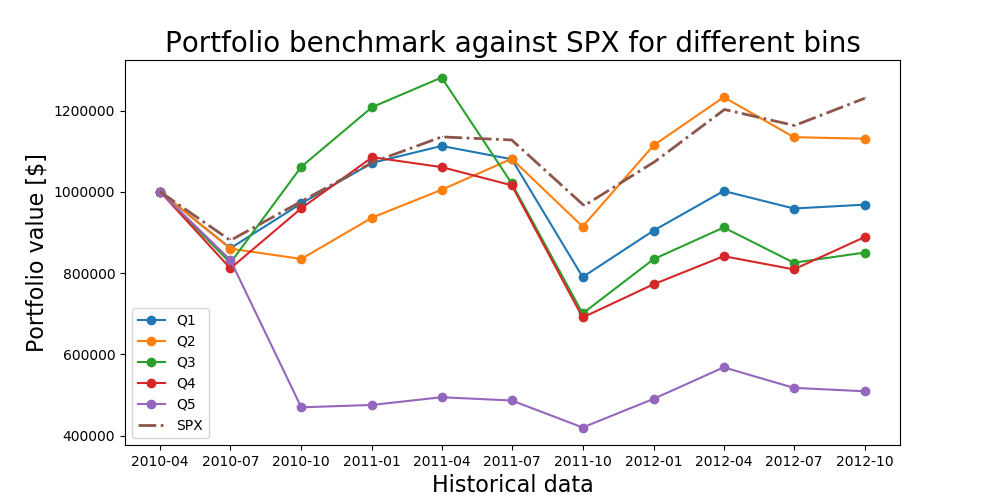

In [52]:
index_name = 'SPX'
display.diff_vs_benchmark(pf_values, index_name, index_data, s)

In [ ]:
# Output the data for the pf value
for qtr in s['list_qtr'][s['lag']:]:
    print(qtr, pf_values['diff_jaccard']['Q5'][qtr][0])

In [53]:
post_processing.dump_cik_scores(cik_scores, s)

100%|██████████| 74/74 [00:00<00:00, 6846.48it/s]


In [54]:
del cik_scores

In [55]:
cik_scores = postgres.retrieve_cik_scores(connector, 851968, s)

SELECT * FROM cik_scores WHERE cik = '851968';


In [56]:
# [DEBUG] Show the Apple data for that time period
# extracted_cik_scores = cik_scores[data_to_process[0][0]]
data_to_process = ([k, v, {**s}, lm_dictionary] for k, v in cik_path.items())
cik = next(data_to_process)[0]
extracted_cik_scores = cik_scores[cik]
# extracted_cik_scores

In [57]:
#ticker = lookup[320193]
ticker = lookup[cik]
start_date = qtrs.qtr_to_day(s['time_range'][0], 'first', date_format='datetime')
stop_date = qtrs.qtr_to_day(s['time_range'][1], 'last', date_format='datetime')

#print(s['time_range'], start_date)
#print(s['time_range'], stop_date)
extracted_stock_data = {k: v for k, v in stock_data[ticker].items() if start_date <= k <= stop_date}
#print(extracted_data)


# Display the data

## For a given ticker

### Metrics vs stock price

[INFO] Publication dates: 2010-05-03
[INFO] Publication dates: 2010-08-06
[INFO] Publication dates: 2010-11-05
[INFO] Publication dates: 2011-03-01
[INFO] Publication dates: 2011-05-06
[INFO] Publication dates: 2011-08-05
[INFO] Publication dates: 2011-11-04
[INFO] Publication dates: 2012-02-29
[INFO] Publication dates: 2012-05-04
[INFO] Publication dates: 2012-08-03
[INFO] Publication dates: 2012-11-02


<IPython.core.display.Javascript object>


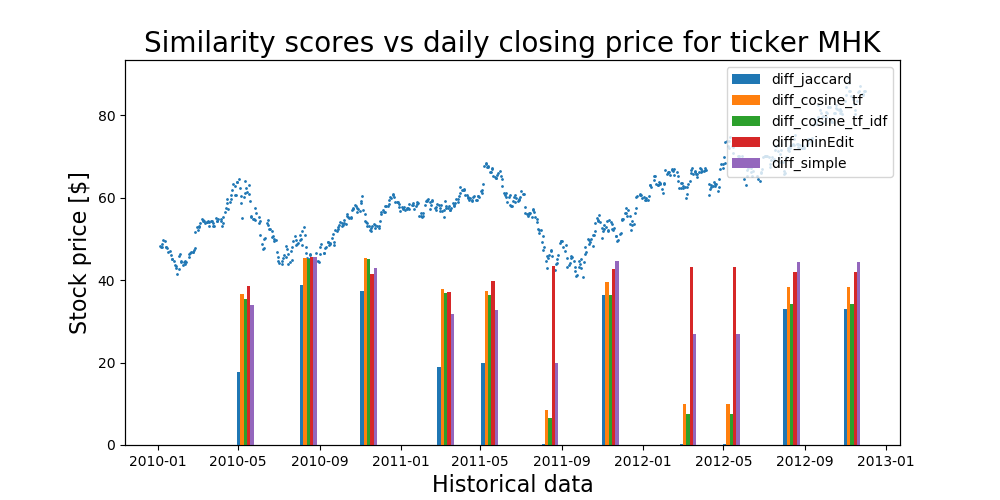

In [58]:
display.diff_vs_stock(extracted_cik_scores, extracted_stock_data, ticker, s, method='diff')

### Sentiment vs stock price

[INFO] Publication dates: 2010-05-03
[INFO] Publication dates: 2010-08-06
[INFO] Publication dates: 2010-11-05
[INFO] Publication dates: 2011-03-01
[INFO] Publication dates: 2011-05-06
[INFO] Publication dates: 2011-08-05
[INFO] Publication dates: 2011-11-04
[INFO] Publication dates: 2012-02-29
[INFO] Publication dates: 2012-05-04
[INFO] Publication dates: 2012-08-03
[INFO] Publication dates: 2012-11-02


<IPython.core.display.Javascript object>


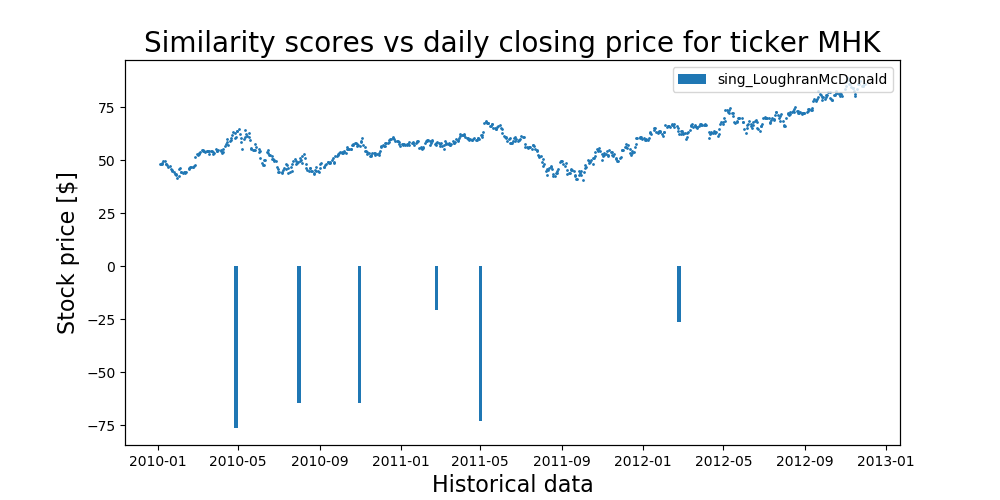

In [59]:
display.diff_vs_stock(extracted_cik_scores, extracted_stock_data, ticker, s, method='sentiment')